# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    sep_conv1=separable_conv2d_batchnorm(input_layer,filters,strides)
    output_layer=sep_conv1
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
     # TODO Upsample the small input layer using the bilinear_upsample() function.
    up_layer1=bilinear_upsample(small_ip_layer)
    
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    up_layer1=layers.concatenate([up_layer1,large_ip_layer])
    # TODO Add some number of separable convolution layers
    up_layer2=separable_conv2d_batchnorm(up_layer1, filters, strides=1)
#     up_layer3=separable_conv2d_batchnorm(up_layer2, filters, strides=1)
    
    output_layer=up_layer2
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    print("Feature layer", inputs.shape)
    encoder_1_layer = encoder_block(inputs, 32, 2)
    encoder_2_layer = encoder_block(encoder_1_layer, 64, 2)
    encoder_3_layer = encoder_block(encoder_2_layer, 128, 2)
    print("Encoder 1", encoder_1_layer.shape)
    print("Encoder 2", encoder_2_layer.shape)
    print("Encoder 3", encoder_3_layer.shape)
    
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    conv_1_1_layer = conv2d_batchnorm(encoder_3_layer, 128, 1, 1)
    print("1x1 Conv", conv_1_1_layer.shape)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    decoder_1_layer = decoder_block(conv_1_1_layer, encoder_2_layer, 128)
    print("Decoder 1", decoder_1_layer.shape)
    decoder_2_layer = decoder_block(decoder_1_layer, encoder_1_layer, 64)
    print("Decoder 2", decoder_2_layer.shape)
    decoder_3_layer = decoder_block(decoder_2_layer, inputs, 32)
    print("Decoder 3", decoder_3_layer.shape)
    
    x=decoder_3_layer
    
    output_layer=layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(x)
    print("Output_layer", output_layer.shape)
    
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return output_layer

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
def score_all():
    run_num = 'run_1'

    val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 
    val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 
    val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')
    true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)
    true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)
    true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)
    true_pos = true_pos1 + true_pos2 + true_pos3
    false_pos = false_pos1 + false_pos2 + false_pos3
    false_neg = false_neg1 + false_neg2 + false_neg3

    weight = true_pos/(true_pos+false_neg+false_pos)
    print(weight)
    final_IoU = (iou1 + iou3)/2
    print(final_IoU)
    final_score = final_IoU * weight
    print(final_score)

Feature layer (?, 160, 160, 3)
Encoder 1 (?, 80, 80, 32)
Encoder 2 (?, 40, 40, 64)
Encoder 3 (?, 20, 20, 128)
1x1 Conv (?, 20, 20, 128)
Decoder 1 (?, 40, 40, 128)
Decoder 2 (?, 80, 80, 64)
Decoder 3 (?, 160, 160, 32)
Output_layer (?, 160, 160, 3)
Epoch 1/40
127/128 [============================>.] - ETA: 0s - loss: 0.1822

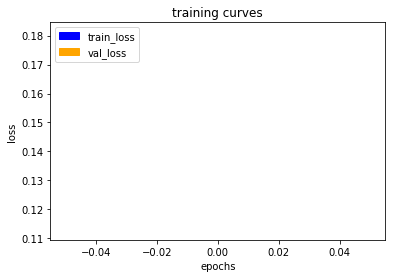

128/128 [==============================] - 56s - loss: 0.1812 - val_loss: 0.1129
Epoch 2/40
127/128 [============================>.] - ETA: 0s - loss: 0.0460

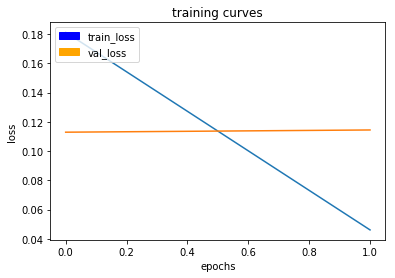

128/128 [==============================] - 55s - loss: 0.0460 - val_loss: 0.1144
Epoch 3/40
127/128 [============================>.] - ETA: 0s - loss: 0.0397

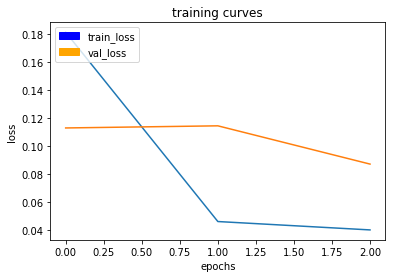

128/128 [==============================] - 55s - loss: 0.0401 - val_loss: 0.0871
Epoch 4/40
127/128 [============================>.] - ETA: 0s - loss: 0.0378

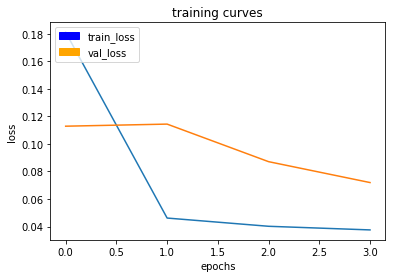

128/128 [==============================] - 54s - loss: 0.0377 - val_loss: 0.0719
Epoch 5/40
127/128 [============================>.] - ETA: 0s - loss: 0.0333

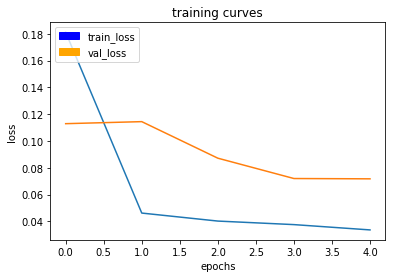

128/128 [==============================] - 54s - loss: 0.0336 - val_loss: 0.0717
Epoch 6/40
127/128 [============================>.] - ETA: 0s - loss: 0.0336

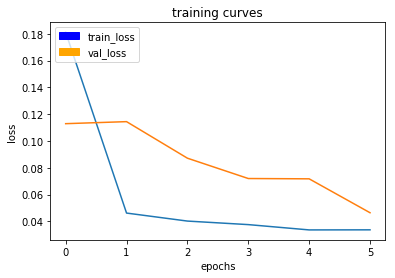

128/128 [==============================] - 55s - loss: 0.0336 - val_loss: 0.0464
Epoch 7/40
127/128 [============================>.] - ETA: 0s - loss: 0.0330

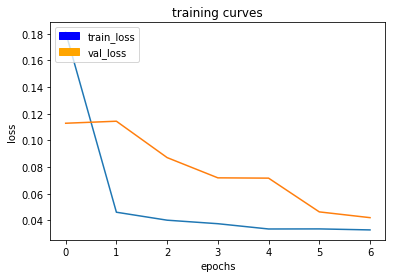

128/128 [==============================] - 55s - loss: 0.0329 - val_loss: 0.0421
Epoch 8/40
127/128 [============================>.] - ETA: 0s - loss: 0.0299

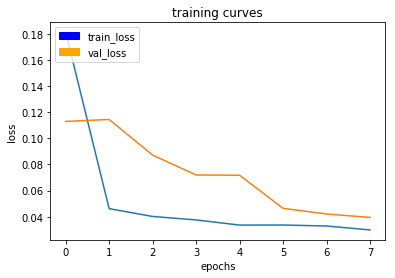

128/128 [==============================] - 55s - loss: 0.0299 - val_loss: 0.0394
Epoch 9/40
127/128 [============================>.] - ETA: 0s - loss: 0.0289

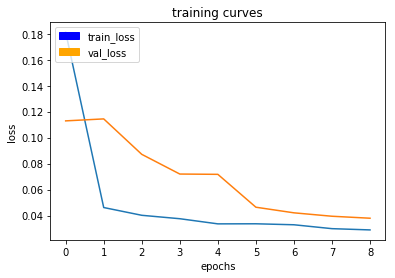

128/128 [==============================] - 55s - loss: 0.0289 - val_loss: 0.0379
Epoch 10/40
127/128 [============================>.] - ETA: 0s - loss: 0.0293

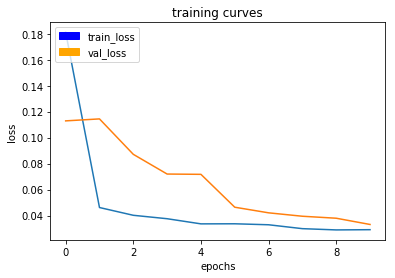

128/128 [==============================] - 55s - loss: 0.0292 - val_loss: 0.0331
Epoch 11/40
127/128 [============================>.] - ETA: 0s - loss: 0.0262

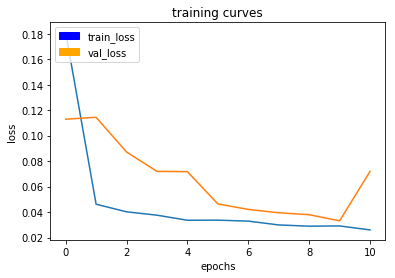

128/128 [==============================] - 55s - loss: 0.0262 - val_loss: 0.0719
Epoch 12/40
127/128 [============================>.] - ETA: 0s - loss: 0.0250

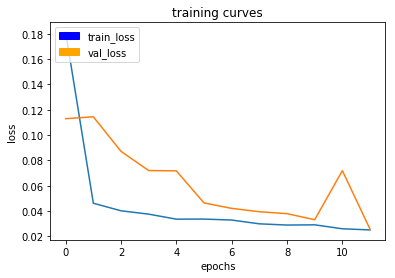

128/128 [==============================] - 55s - loss: 0.0250 - val_loss: 0.0256
Epoch 13/40
127/128 [============================>.] - ETA: 0s - loss: 0.0441

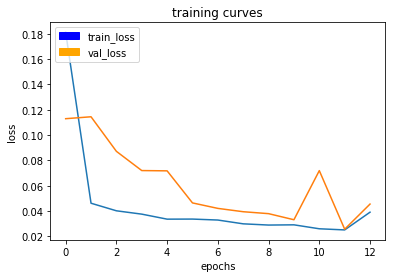

128/128 [==============================] - 55s - loss: 0.0439 - val_loss: 0.0455
Epoch 14/40
127/128 [============================>.] - ETA: 0s - loss: 0.0319

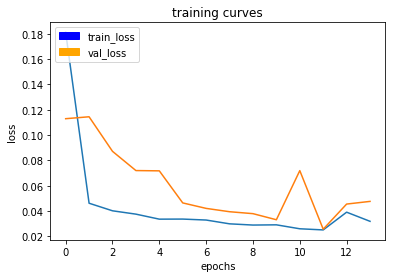

128/128 [==============================] - 55s - loss: 0.0318 - val_loss: 0.0476
Epoch 15/40
127/128 [============================>.] - ETA: 0s - loss: 0.0274

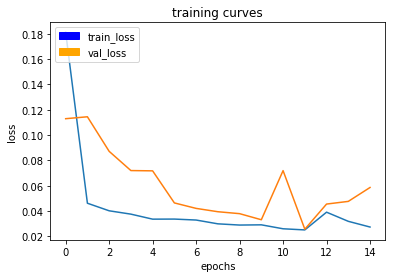

128/128 [==============================] - 54s - loss: 0.0273 - val_loss: 0.0586
Epoch 16/40
127/128 [============================>.] - ETA: 0s - loss: 0.0263

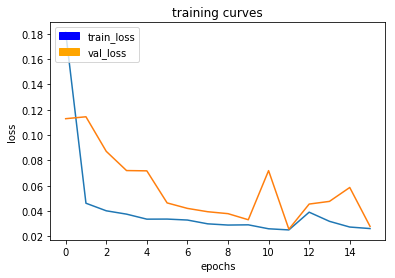

128/128 [==============================] - 54s - loss: 0.0262 - val_loss: 0.0279
Epoch 17/40
127/128 [============================>.] - ETA: 0s - loss: 0.0266

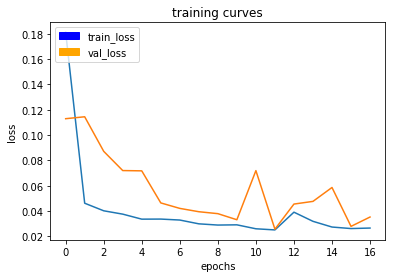

128/128 [==============================] - 54s - loss: 0.0265 - val_loss: 0.0353
Epoch 18/40
127/128 [============================>.] - ETA: 0s - loss: 0.0236

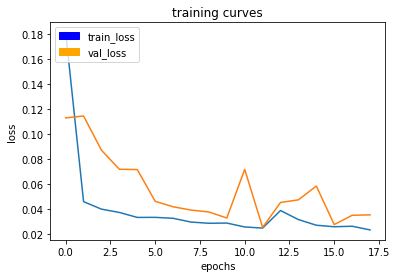

128/128 [==============================] - 54s - loss: 0.0236 - val_loss: 0.0356
Epoch 19/40
127/128 [============================>.] - ETA: 0s - loss: 0.0241

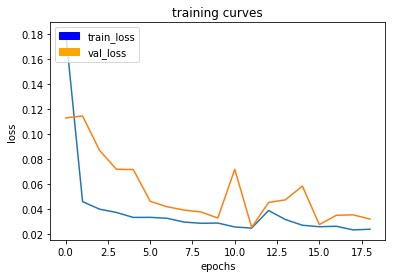

128/128 [==============================] - 54s - loss: 0.0241 - val_loss: 0.0323
Epoch 20/40
127/128 [============================>.] - ETA: 0s - loss: 0.0238

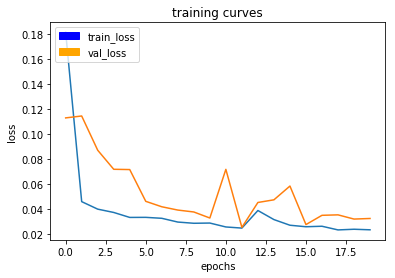

128/128 [==============================] - 54s - loss: 0.0238 - val_loss: 0.0327
Epoch 21/40
127/128 [============================>.] - ETA: 0s - loss: 0.0227

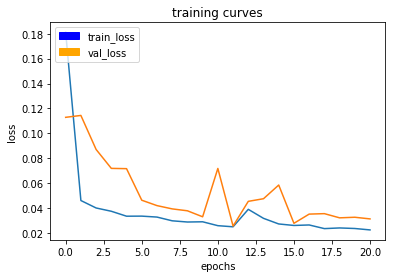

128/128 [==============================] - 54s - loss: 0.0226 - val_loss: 0.0314
Epoch 22/40
127/128 [============================>.] - ETA: 0s - loss: 0.0224

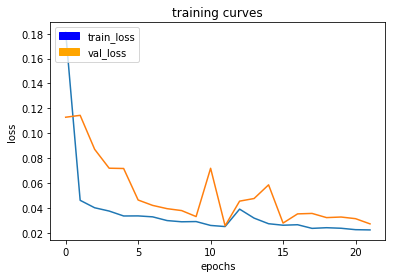

128/128 [==============================] - 55s - loss: 0.0223 - val_loss: 0.0272
Epoch 23/40
127/128 [============================>.] - ETA: 0s - loss: 0.0222

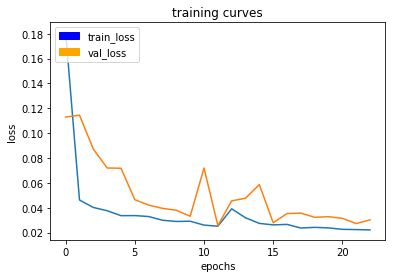

128/128 [==============================] - 55s - loss: 0.0221 - val_loss: 0.0302
Epoch 24/40
127/128 [============================>.] - ETA: 0s - loss: 0.0213

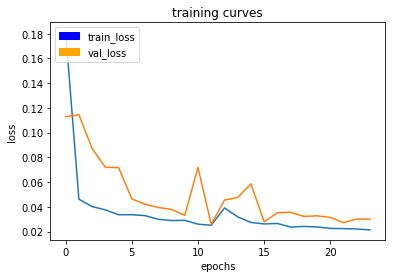

128/128 [==============================] - 55s - loss: 0.0213 - val_loss: 0.0300
Epoch 25/40
127/128 [============================>.] - ETA: 0s - loss: 0.0208

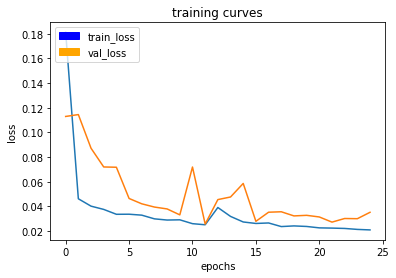

128/128 [==============================] - 55s - loss: 0.0210 - val_loss: 0.0352
Epoch 26/40
127/128 [============================>.] - ETA: 0s - loss: 0.0205

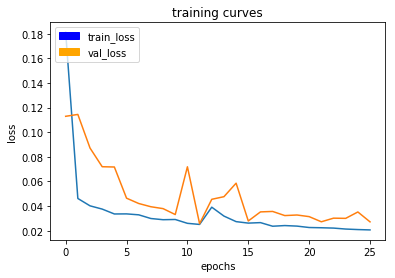

128/128 [==============================] - 55s - loss: 0.0206 - val_loss: 0.0272
Epoch 27/40
127/128 [============================>.] - ETA: 0s - loss: 0.0213

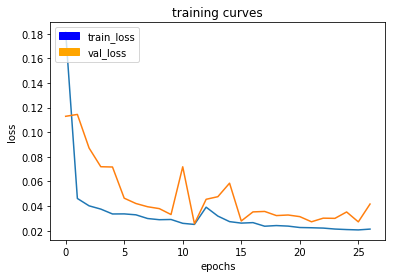

128/128 [==============================] - 55s - loss: 0.0212 - val_loss: 0.0416
Epoch 28/40
127/128 [============================>.] - ETA: 0s - loss: 0.0189

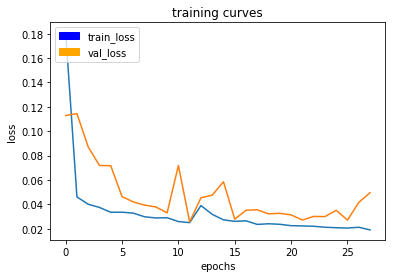

128/128 [==============================] - 55s - loss: 0.0192 - val_loss: 0.0496
Epoch 29/40
127/128 [============================>.] - ETA: 0s - loss: 0.0209

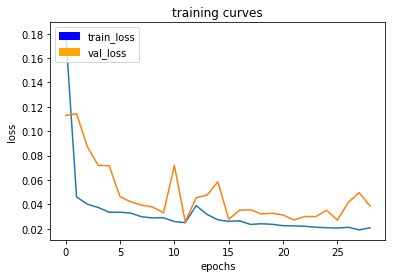

128/128 [==============================] - 54s - loss: 0.0208 - val_loss: 0.0387
Epoch 30/40
127/128 [============================>.] - ETA: 0s - loss: 0.0188

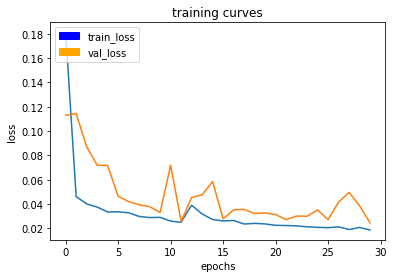

128/128 [==============================] - 55s - loss: 0.0188 - val_loss: 0.0246
Epoch 31/40
127/128 [============================>.] - ETA: 0s - loss: 0.0200

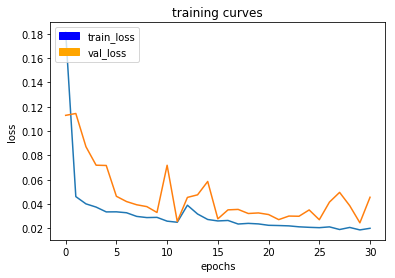

128/128 [==============================] - 55s - loss: 0.0200 - val_loss: 0.0456
Epoch 32/40
127/128 [============================>.] - ETA: 0s - loss: 0.0196

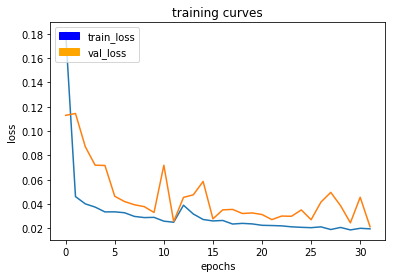

128/128 [==============================] - 54s - loss: 0.0196 - val_loss: 0.0214
Epoch 33/40
127/128 [============================>.] - ETA: 0s - loss: 0.0216

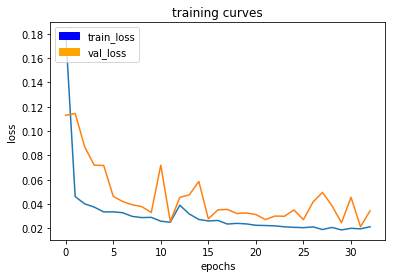

128/128 [==============================] - 54s - loss: 0.0215 - val_loss: 0.0344
Epoch 34/40
127/128 [============================>.] - ETA: 0s - loss: 0.0186

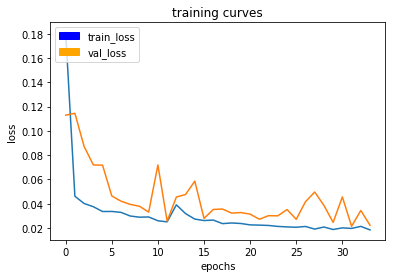

128/128 [==============================] - 54s - loss: 0.0186 - val_loss: 0.0223
Epoch 35/40
127/128 [============================>.] - ETA: 0s - loss: 0.0191

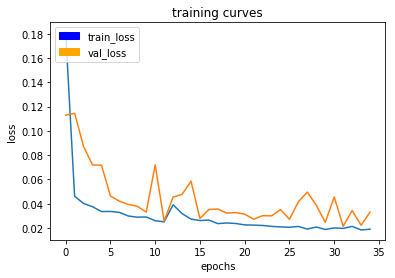

128/128 [==============================] - 54s - loss: 0.0191 - val_loss: 0.0331
Epoch 36/40
127/128 [============================>.] - ETA: 0s - loss: 0.0204

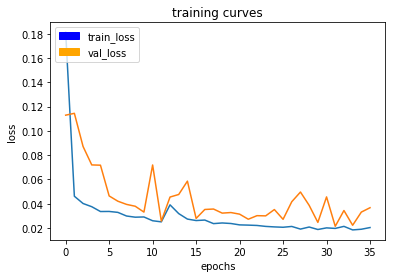

128/128 [==============================] - 54s - loss: 0.0204 - val_loss: 0.0367
Epoch 37/40
127/128 [============================>.] - ETA: 0s - loss: 0.0186

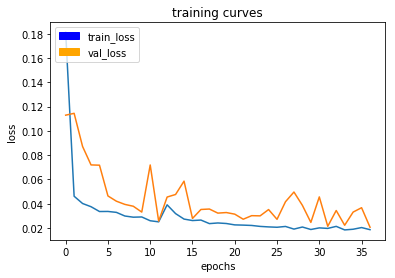

128/128 [==============================] - 55s - loss: 0.0186 - val_loss: 0.0206
Epoch 38/40
127/128 [============================>.] - ETA: 0s - loss: 0.0177

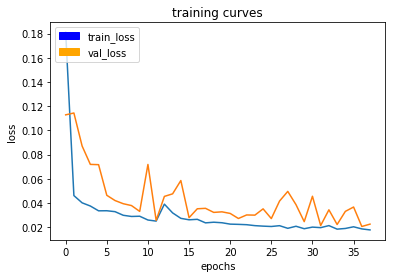

128/128 [==============================] - 54s - loss: 0.0177 - val_loss: 0.0226
Epoch 39/40
127/128 [============================>.] - ETA: 0s - loss: 0.0178

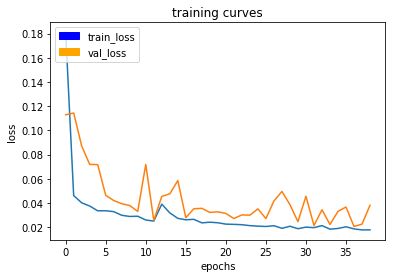

128/128 [==============================] - 54s - loss: 0.0178 - val_loss: 0.0382
Epoch 40/40
127/128 [============================>.] - ETA: 0s - loss: 0.0202

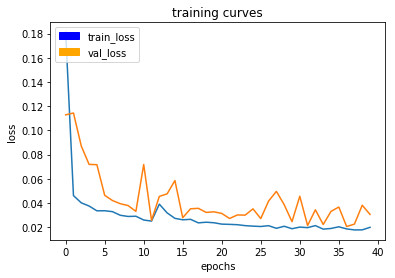

128/128 [==============================] - 54s - loss: 0.0202 - val_loss: 0.0306
number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9935548534676846
average intersection over union for other people is 0.31150386595980856
average intersection over union for the hero is 0.8724654376455174
number true positives: 539, number false positives: 0, number false negatives: 0
number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9836993596588174
average intersection over union for other people is 0.6150499881776965
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 159, number false negatives: 0
number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9957555942074586
average intersection over union for other people is 0.419034053625

In [8]:
# Run One
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

learning_rate = 0.01
batch_size = 32
num_epochs = 40
steps_per_epoch = int(4131/batch_size)-1#200
validation_steps = int(1000/batch_size)-1
workers = 1 # Using GPU.
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

# Save your trained model weights
weight_file_name = 'model_weights-1'
model_tools.save_network(model, weight_file_name)
score_all()

Feature layer (?, 160, 160, 3)
Encoder 1 (?, 80, 80, 32)
Encoder 2 (?, 40, 40, 64)
Encoder 3 (?, 20, 20, 128)
1x1 Conv (?, 20, 20, 128)
Decoder 1 (?, 40, 40, 128)
Decoder 2 (?, 80, 80, 64)
Decoder 3 (?, 160, 160, 32)
Output_layer (?, 160, 160, 3)
Epoch 1/40
127/128 [============================>.] - ETA: 0s - loss: 0.7046

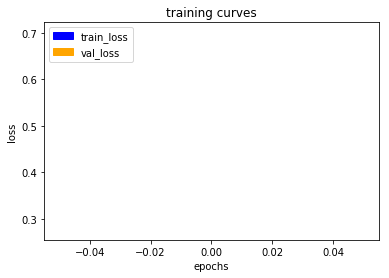

128/128 [==============================] - 55s - loss: 0.7013 - val_loss: 0.2762
Epoch 2/40
127/128 [============================>.] - ETA: 0s - loss: 0.1478

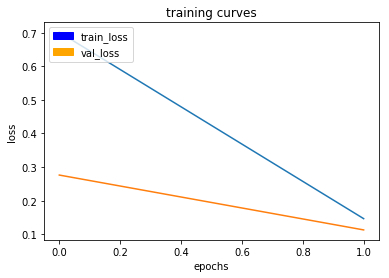

128/128 [==============================] - 54s - loss: 0.1474 - val_loss: 0.1129
Epoch 3/40
127/128 [============================>.] - ETA: 0s - loss: 0.0677

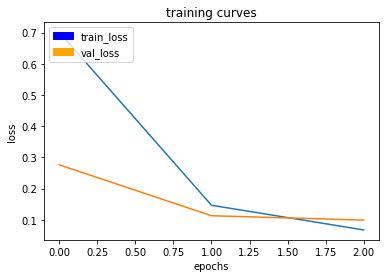

128/128 [==============================] - 54s - loss: 0.0677 - val_loss: 0.0988
Epoch 4/40
127/128 [============================>.] - ETA: 0s - loss: 0.0505

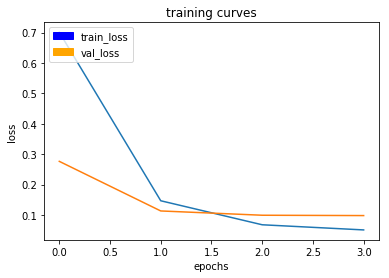

128/128 [==============================] - 54s - loss: 0.0505 - val_loss: 0.0977
Epoch 5/40
127/128 [============================>.] - ETA: 0s - loss: 0.0438

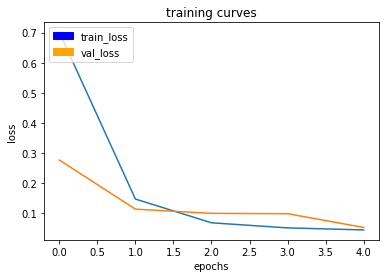

128/128 [==============================] - 54s - loss: 0.0437 - val_loss: 0.0520
Epoch 6/40
127/128 [============================>.] - ETA: 0s - loss: 0.0393

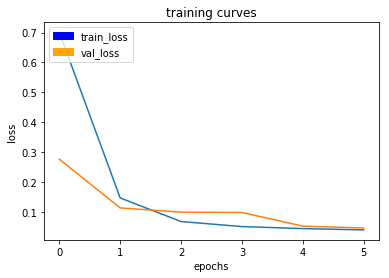

128/128 [==============================] - 54s - loss: 0.0393 - val_loss: 0.0456
Epoch 7/40
127/128 [============================>.] - ETA: 0s - loss: 0.0354

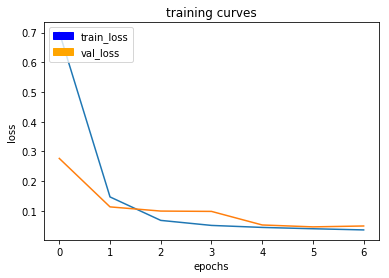

128/128 [==============================] - 54s - loss: 0.0354 - val_loss: 0.0486
Epoch 8/40
127/128 [============================>.] - ETA: 0s - loss: 0.0352

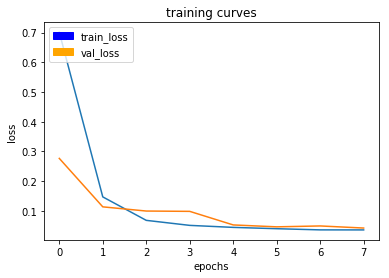

128/128 [==============================] - 54s - loss: 0.0352 - val_loss: 0.0415
Epoch 9/40
127/128 [============================>.] - ETA: 0s - loss: 0.0321

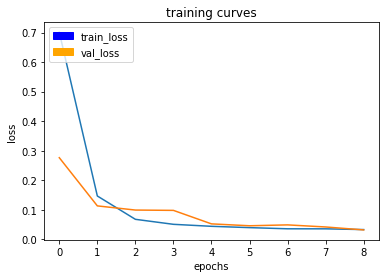

128/128 [==============================] - 54s - loss: 0.0329 - val_loss: 0.0315
Epoch 10/40
127/128 [============================>.] - ETA: 0s - loss: 0.0325

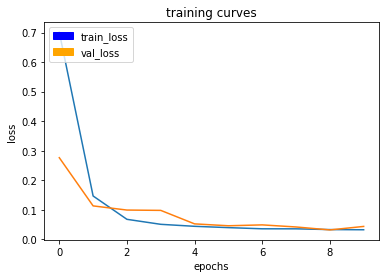

128/128 [==============================] - 54s - loss: 0.0325 - val_loss: 0.0433
Epoch 11/40
127/128 [============================>.] - ETA: 0s - loss: 0.0291

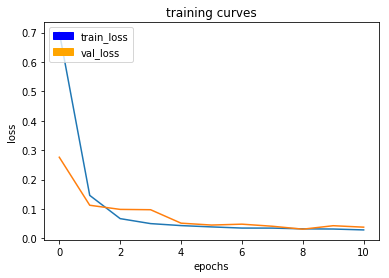

128/128 [==============================] - 54s - loss: 0.0290 - val_loss: 0.0384
Epoch 12/40
127/128 [============================>.] - ETA: 0s - loss: 0.0283

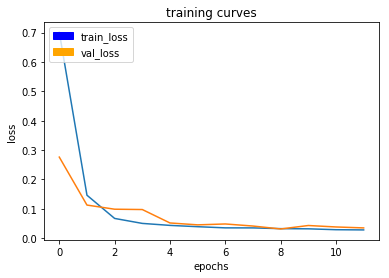

128/128 [==============================] - 55s - loss: 0.0282 - val_loss: 0.0352
Epoch 13/40
127/128 [============================>.] - ETA: 0s - loss: 0.0289

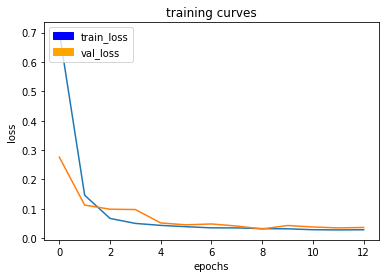

128/128 [==============================] - 54s - loss: 0.0289 - val_loss: 0.0367
Epoch 14/40
127/128 [============================>.] - ETA: 0s - loss: 0.0254

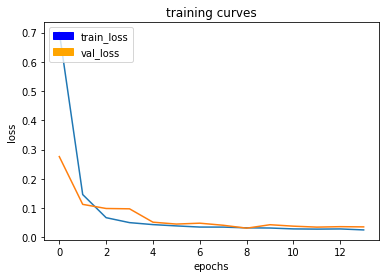

128/128 [==============================] - 54s - loss: 0.0255 - val_loss: 0.0359
Epoch 15/40
127/128 [============================>.] - ETA: 0s - loss: 0.0268

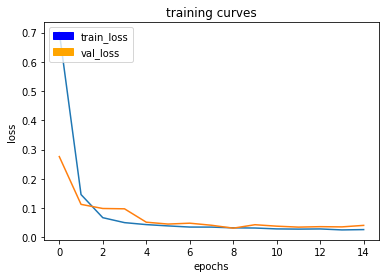

128/128 [==============================] - 54s - loss: 0.0268 - val_loss: 0.0411
Epoch 16/40
127/128 [============================>.] - ETA: 0s - loss: 0.0258

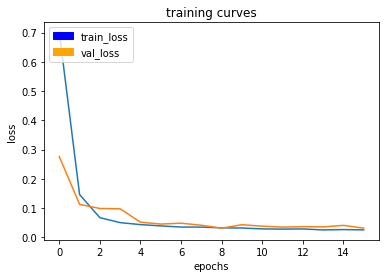

128/128 [==============================] - 54s - loss: 0.0259 - val_loss: 0.0317
Epoch 17/40
127/128 [============================>.] - ETA: 0s - loss: 0.0255

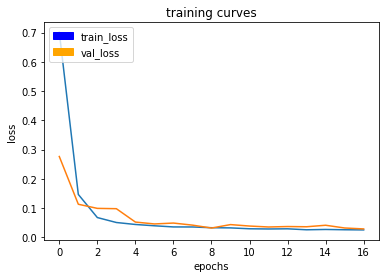

128/128 [==============================] - 54s - loss: 0.0254 - val_loss: 0.0285
Epoch 18/40
127/128 [============================>.] - ETA: 0s - loss: 0.0245

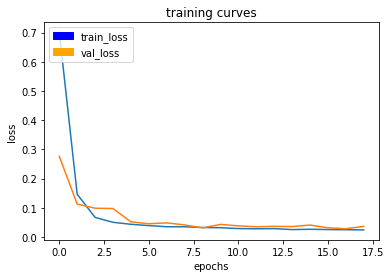

128/128 [==============================] - 54s - loss: 0.0244 - val_loss: 0.0366
Epoch 19/40
127/128 [============================>.] - ETA: 0s - loss: 0.0248

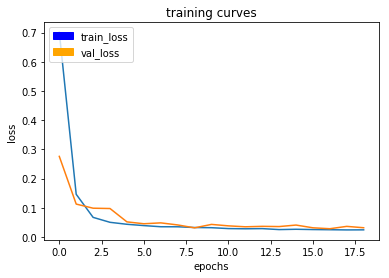

128/128 [==============================] - 54s - loss: 0.0248 - val_loss: 0.0319
Epoch 20/40
127/128 [============================>.] - ETA: 0s - loss: 0.0219

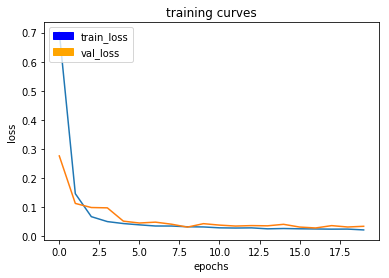

128/128 [==============================] - 54s - loss: 0.0219 - val_loss: 0.0343
Epoch 21/40
127/128 [============================>.] - ETA: 0s - loss: 0.0244

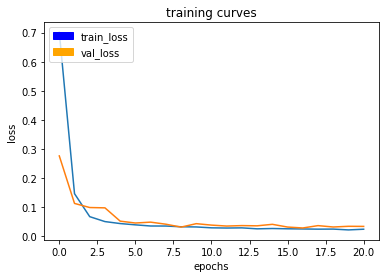

128/128 [==============================] - 54s - loss: 0.0244 - val_loss: 0.0339
Epoch 22/40
127/128 [============================>.] - ETA: 0s - loss: 0.0230

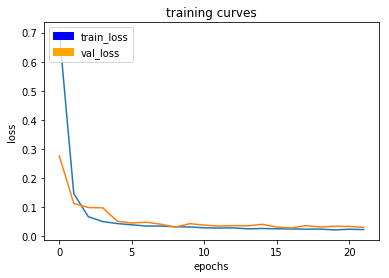

128/128 [==============================] - 54s - loss: 0.0230 - val_loss: 0.0307
Epoch 23/40
127/128 [============================>.] - ETA: 0s - loss: 0.0215

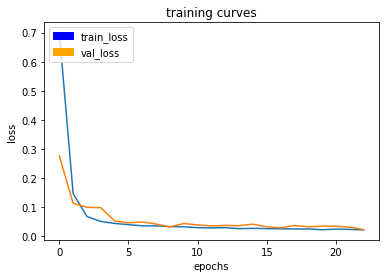

128/128 [==============================] - 54s - loss: 0.0214 - val_loss: 0.0225
Epoch 24/40
127/128 [============================>.] - ETA: 0s - loss: 0.0239

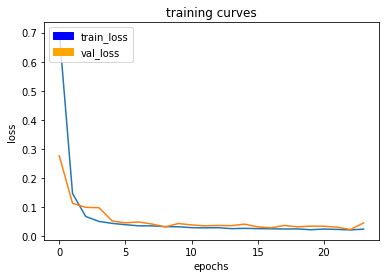

128/128 [==============================] - 54s - loss: 0.0240 - val_loss: 0.0454
Epoch 25/40
127/128 [============================>.] - ETA: 0s - loss: 0.0211

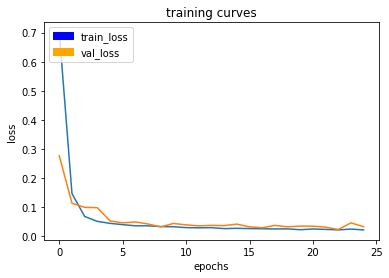

128/128 [==============================] - 54s - loss: 0.0211 - val_loss: 0.0321
Epoch 26/40
127/128 [============================>.] - ETA: 0s - loss: 0.0217

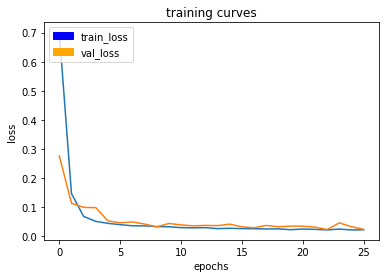

128/128 [==============================] - 54s - loss: 0.0216 - val_loss: 0.0230
Epoch 27/40
127/128 [============================>.] - ETA: 0s - loss: 0.0209

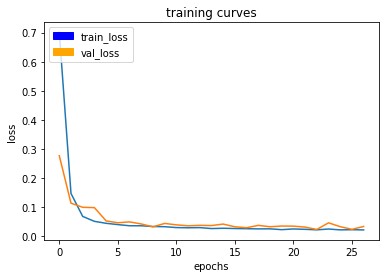

128/128 [==============================] - 54s - loss: 0.0210 - val_loss: 0.0328
Epoch 28/40
127/128 [============================>.] - ETA: 0s - loss: 0.0215

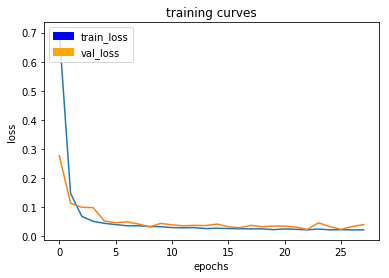

128/128 [==============================] - 54s - loss: 0.0214 - val_loss: 0.0392
Epoch 29/40
127/128 [============================>.] - ETA: 0s - loss: 0.0190

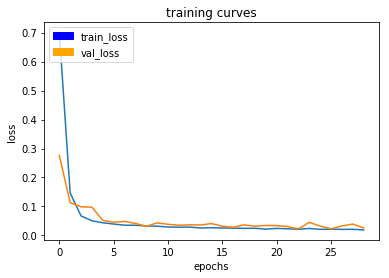

128/128 [==============================] - 54s - loss: 0.0190 - val_loss: 0.0261
Epoch 30/40
127/128 [============================>.] - ETA: 0s - loss: 0.0200

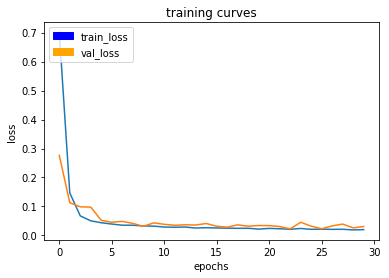

128/128 [==============================] - 54s - loss: 0.0200 - val_loss: 0.0307
Epoch 31/40
127/128 [============================>.] - ETA: 0s - loss: 0.0189

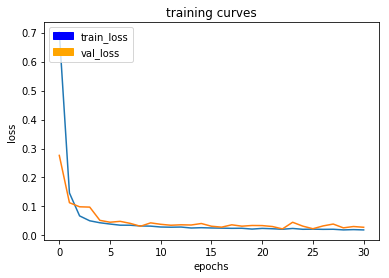

128/128 [==============================] - 54s - loss: 0.0190 - val_loss: 0.0281
Epoch 32/40
127/128 [============================>.] - ETA: 0s - loss: 0.0203

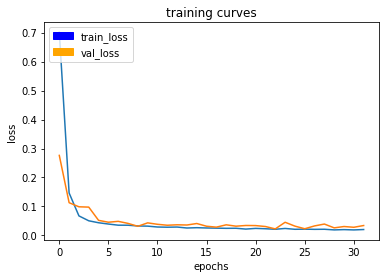

128/128 [==============================] - 54s - loss: 0.0203 - val_loss: 0.0342
Epoch 33/40
127/128 [============================>.] - ETA: 0s - loss: 0.0186

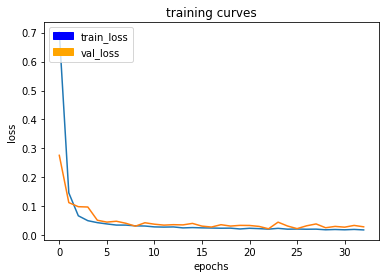

128/128 [==============================] - 54s - loss: 0.0186 - val_loss: 0.0293
Epoch 34/40
127/128 [============================>.] - ETA: 0s - loss: 0.0194

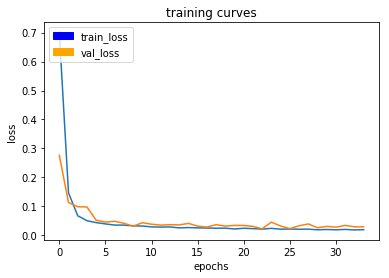

128/128 [==============================] - 54s - loss: 0.0194 - val_loss: 0.0291
Epoch 35/40
127/128 [============================>.] - ETA: 0s - loss: 0.0197

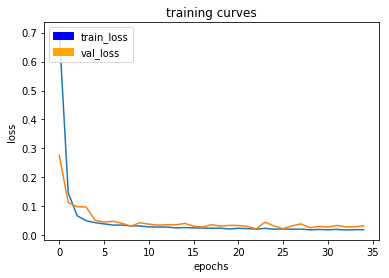

128/128 [==============================] - 54s - loss: 0.0196 - val_loss: 0.0332
Epoch 36/40
127/128 [============================>.] - ETA: 0s - loss: 0.0182

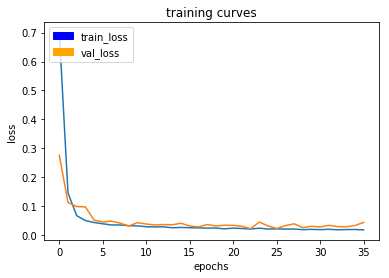

128/128 [==============================] - 54s - loss: 0.0182 - val_loss: 0.0439
Epoch 37/40
127/128 [============================>.] - ETA: 0s - loss: 0.0202

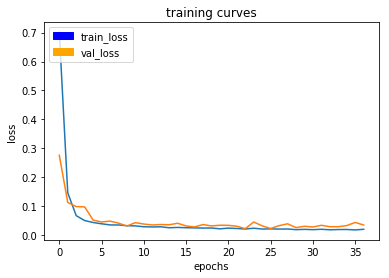

128/128 [==============================] - 55s - loss: 0.0202 - val_loss: 0.0350
Epoch 38/40
127/128 [============================>.] - ETA: 0s - loss: 0.0172

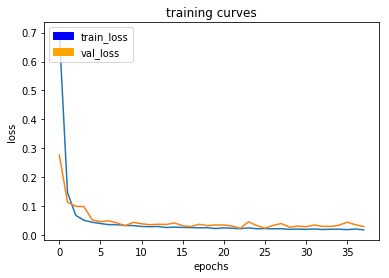

128/128 [==============================] - 54s - loss: 0.0172 - val_loss: 0.0288
Epoch 39/40
127/128 [============================>.] - ETA: 0s - loss: 0.0183

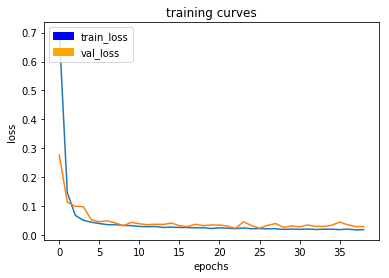

128/128 [==============================] - 54s - loss: 0.0182 - val_loss: 0.0290
Epoch 40/40
127/128 [============================>.] - ETA: 0s - loss: 0.0173

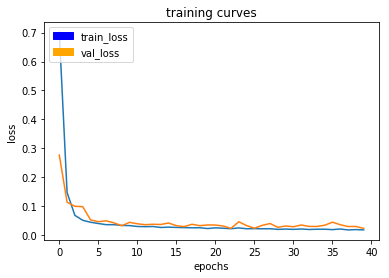

128/128 [==============================] - 54s - loss: 0.0173 - val_loss: 0.0225
number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9954210152494207
average intersection over union for other people is 0.33009729734842935
average intersection over union for the hero is 0.9050826806530476
number true positives: 539, number false positives: 0, number false negatives: 0
number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9862641114837831
average intersection over union for other people is 0.7095807043200734
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 73, number false negatives: 0
number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9963100854823479
average intersection over union for other people is 0.4094529885338

In [9]:
# Run One
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

learning_rate = 0.001
batch_size = 32
num_epochs = 40
steps_per_epoch = int(4131/batch_size)-1#200
validation_steps = int(1000/batch_size)-1
workers = 1 # Using GPU.
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

# Save your trained model weights
weight_file_name = 'model_weights-lr001'
model_tools.save_network(model, weight_file_name)
score_all()

Feature layer (?, 160, 160, 3)
Encoder 1 (?, 80, 80, 32)
Encoder 2 (?, 40, 40, 64)
Encoder 3 (?, 20, 20, 128)
1x1 Conv (?, 20, 20, 128)
Decoder 1 (?, 40, 40, 128)
Decoder 2 (?, 80, 80, 64)
Decoder 3 (?, 160, 160, 32)
Output_layer (?, 160, 160, 3)
Epoch 1/80
127/128 [============================>.] - ETA: 0s - loss: 0.6876

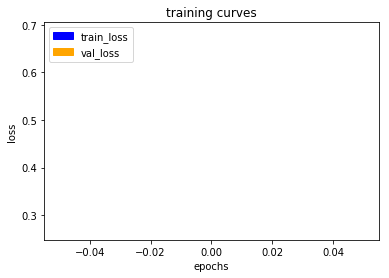

128/128 [==============================] - 55s - loss: 0.6843 - val_loss: 0.2691
Epoch 2/80
127/128 [============================>.] - ETA: 0s - loss: 0.1407

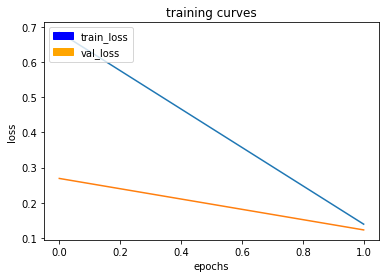

128/128 [==============================] - 55s - loss: 0.1402 - val_loss: 0.1229
Epoch 3/80
127/128 [============================>.] - ETA: 0s - loss: 0.0651

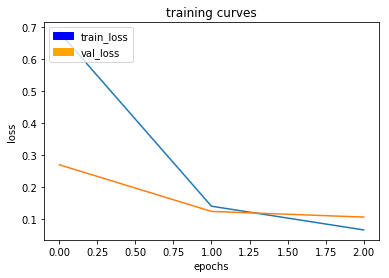

128/128 [==============================] - 54s - loss: 0.0649 - val_loss: 0.1051
Epoch 4/80
127/128 [============================>.] - ETA: 0s - loss: 0.0495

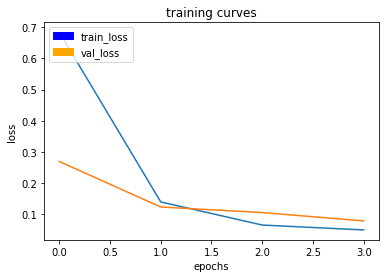

128/128 [==============================] - 55s - loss: 0.0494 - val_loss: 0.0782
Epoch 5/80
127/128 [============================>.] - ETA: 0s - loss: 0.0411

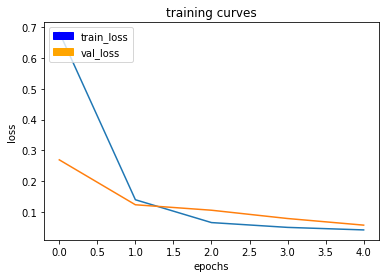

128/128 [==============================] - 54s - loss: 0.0410 - val_loss: 0.0566
Epoch 6/80
127/128 [============================>.] - ETA: 0s - loss: 0.0365

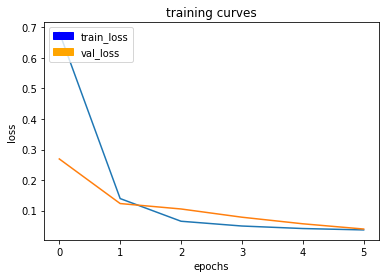

128/128 [==============================] - 55s - loss: 0.0365 - val_loss: 0.0394
Epoch 7/80
127/128 [============================>.] - ETA: 0s - loss: 0.0347

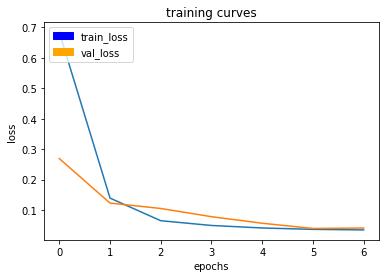

128/128 [==============================] - 54s - loss: 0.0347 - val_loss: 0.0409
Epoch 8/80
127/128 [============================>.] - ETA: 0s - loss: 0.0330

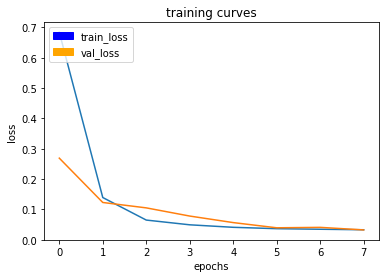

128/128 [==============================] - 55s - loss: 0.0329 - val_loss: 0.0324
Epoch 9/80
127/128 [============================>.] - ETA: 0s - loss: 0.0310

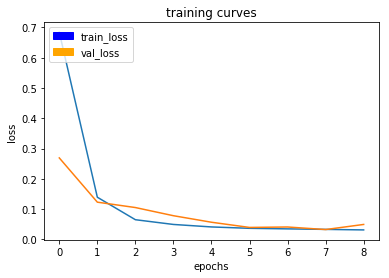

128/128 [==============================] - 55s - loss: 0.0312 - val_loss: 0.0493
Epoch 10/80
127/128 [============================>.] - ETA: 0s - loss: 0.0314

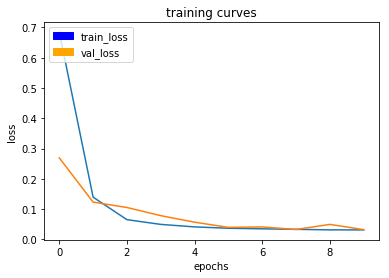

128/128 [==============================] - 55s - loss: 0.0314 - val_loss: 0.0320
Epoch 11/80
127/128 [============================>.] - ETA: 0s - loss: 0.0289

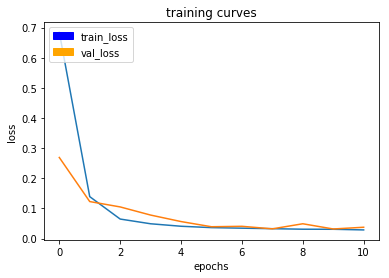

128/128 [==============================] - 55s - loss: 0.0289 - val_loss: 0.0378
Epoch 12/80
127/128 [============================>.] - ETA: 0s - loss: 0.0283

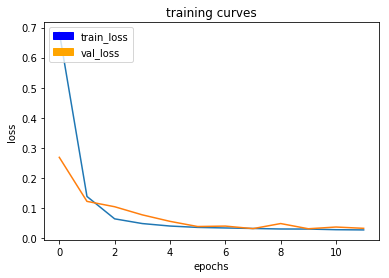

128/128 [==============================] - 54s - loss: 0.0283 - val_loss: 0.0335
Epoch 13/80
127/128 [============================>.] - ETA: 0s - loss: 0.0259

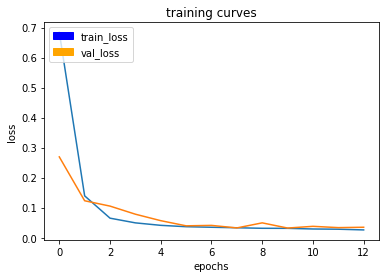

128/128 [==============================] - 55s - loss: 0.0258 - val_loss: 0.0347
Epoch 14/80
127/128 [============================>.] - ETA: 0s - loss: 0.0271

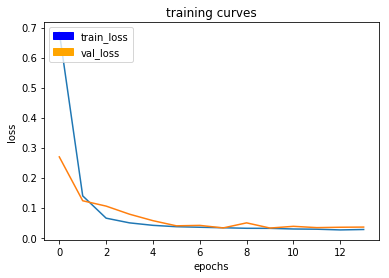

128/128 [==============================] - 55s - loss: 0.0271 - val_loss: 0.0352
Epoch 15/80
127/128 [============================>.] - ETA: 0s - loss: 0.0238

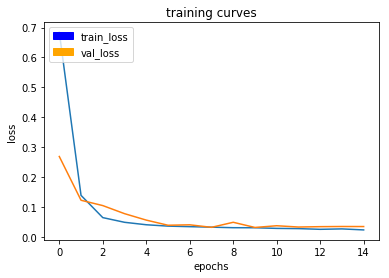

128/128 [==============================] - 55s - loss: 0.0238 - val_loss: 0.0351
Epoch 16/80
127/128 [============================>.] - ETA: 0s - loss: 0.0259

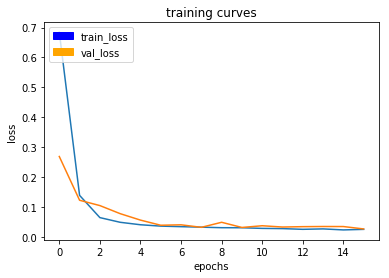

128/128 [==============================] - 55s - loss: 0.0259 - val_loss: 0.0270
Epoch 17/80
127/128 [============================>.] - ETA: 0s - loss: 0.0321

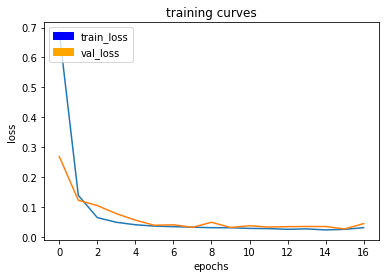

128/128 [==============================] - 55s - loss: 0.0326 - val_loss: 0.0448
Epoch 18/80
127/128 [============================>.] - ETA: 0s - loss: 0.0252

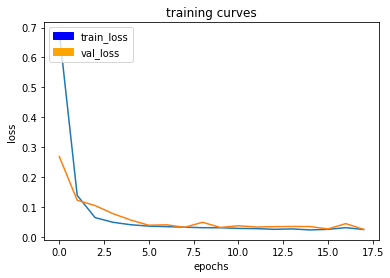

128/128 [==============================] - 55s - loss: 0.0252 - val_loss: 0.0257
Epoch 19/80
127/128 [============================>.] - ETA: 0s - loss: 0.0240

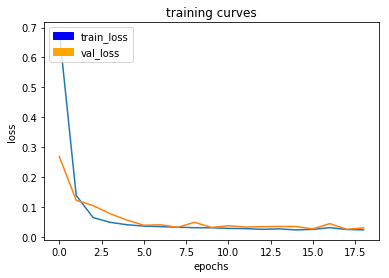

128/128 [==============================] - 55s - loss: 0.0240 - val_loss: 0.0305
Epoch 20/80
127/128 [============================>.] - ETA: 0s - loss: 0.0239

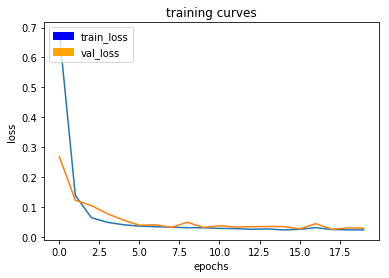

128/128 [==============================] - 55s - loss: 0.0239 - val_loss: 0.0298
Epoch 21/80
127/128 [============================>.] - ETA: 0s - loss: 0.0226

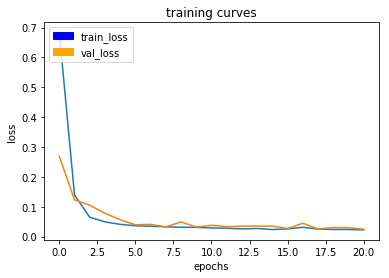

128/128 [==============================] - 55s - loss: 0.0225 - val_loss: 0.0246
Epoch 22/80
127/128 [============================>.] - ETA: 0s - loss: 0.0217

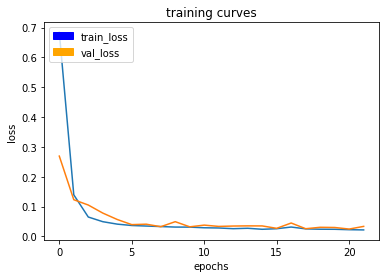

128/128 [==============================] - 55s - loss: 0.0217 - val_loss: 0.0335
Epoch 23/80
127/128 [============================>.] - ETA: 0s - loss: 0.0222

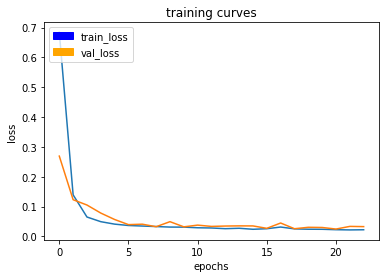

128/128 [==============================] - 55s - loss: 0.0222 - val_loss: 0.0328
Epoch 24/80
127/128 [============================>.] - ETA: 0s - loss: 0.0212

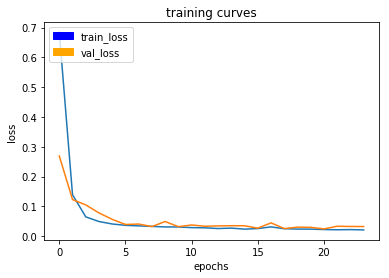

128/128 [==============================] - 55s - loss: 0.0212 - val_loss: 0.0326
Epoch 25/80
127/128 [============================>.] - ETA: 0s - loss: 0.0217

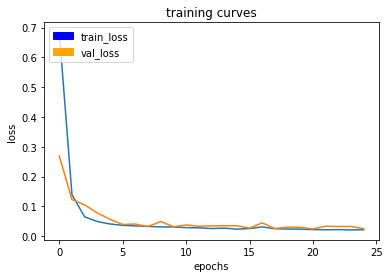

128/128 [==============================] - 55s - loss: 0.0217 - val_loss: 0.0254
Epoch 26/80
127/128 [============================>.] - ETA: 0s - loss: 0.0205

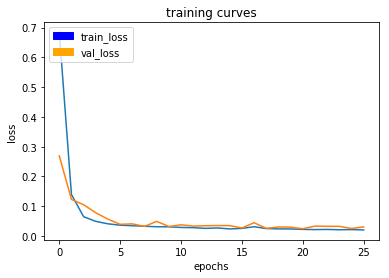

128/128 [==============================] - 55s - loss: 0.0206 - val_loss: 0.0307
Epoch 27/80
127/128 [============================>.] - ETA: 0s - loss: 0.0200

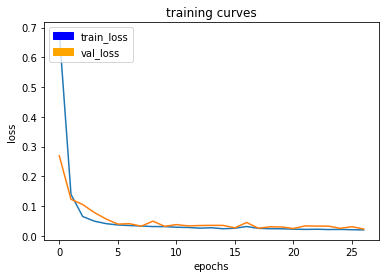

128/128 [==============================] - 55s - loss: 0.0200 - val_loss: 0.0230
Epoch 28/80
127/128 [============================>.] - ETA: 0s - loss: 0.0213

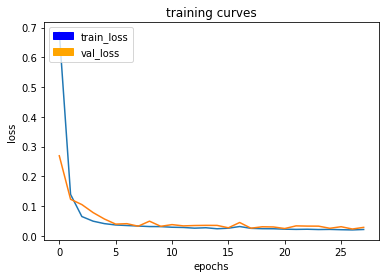

128/128 [==============================] - 55s - loss: 0.0214 - val_loss: 0.0285
Epoch 29/80
127/128 [============================>.] - ETA: 0s - loss: 0.0212

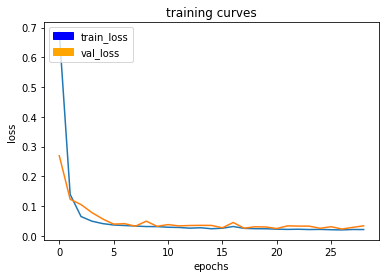

128/128 [==============================] - 55s - loss: 0.0212 - val_loss: 0.0337
Epoch 30/80
127/128 [============================>.] - ETA: 0s - loss: 0.0192

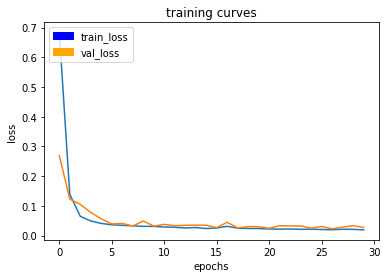

128/128 [==============================] - 55s - loss: 0.0192 - val_loss: 0.0274
Epoch 31/80
127/128 [============================>.] - ETA: 0s - loss: 0.0206

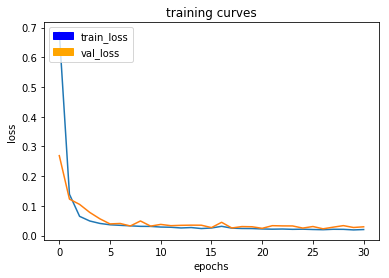

128/128 [==============================] - 55s - loss: 0.0206 - val_loss: 0.0297
Epoch 32/80
127/128 [============================>.] - ETA: 0s - loss: 0.0216

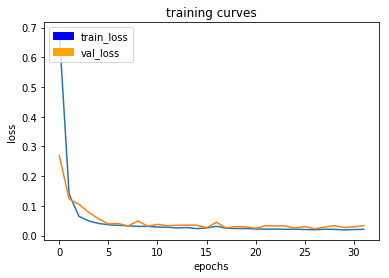

128/128 [==============================] - 55s - loss: 0.0216 - val_loss: 0.0332
Epoch 33/80
127/128 [============================>.] - ETA: 0s - loss: 0.0187

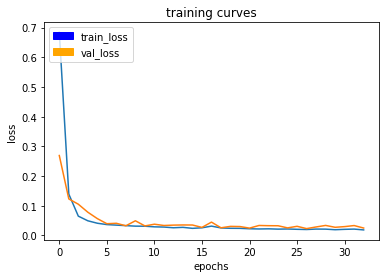

128/128 [==============================] - 55s - loss: 0.0187 - val_loss: 0.0248
Epoch 34/80
127/128 [============================>.] - ETA: 0s - loss: 0.0206

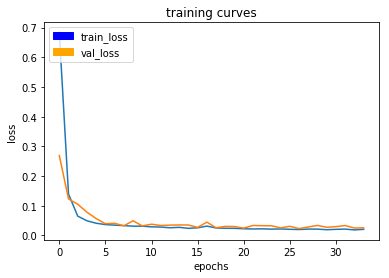

128/128 [==============================] - 55s - loss: 0.0206 - val_loss: 0.0257
Epoch 35/80
127/128 [============================>.] - ETA: 0s - loss: 0.0181

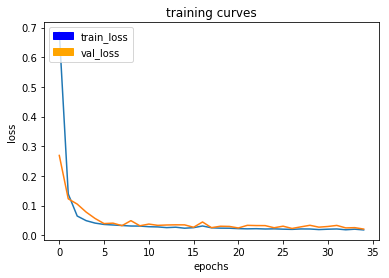

128/128 [==============================] - 55s - loss: 0.0181 - val_loss: 0.0210
Epoch 36/80
127/128 [============================>.] - ETA: 0s - loss: 0.0189

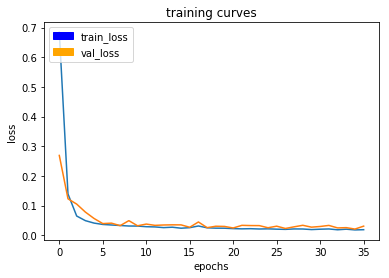

128/128 [==============================] - 55s - loss: 0.0188 - val_loss: 0.0308
Epoch 37/80
127/128 [============================>.] - ETA: 0s - loss: 0.0177

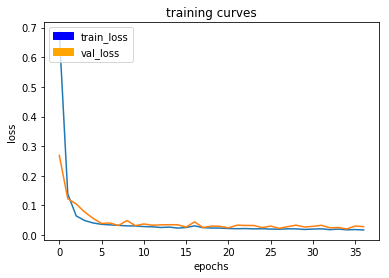

128/128 [==============================] - 55s - loss: 0.0177 - val_loss: 0.0286
Epoch 38/80
127/128 [============================>.] - ETA: 0s - loss: 0.0185

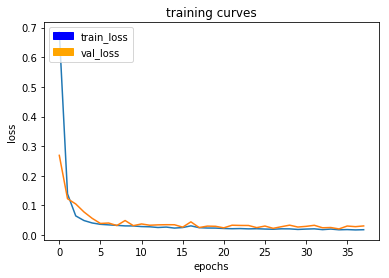

128/128 [==============================] - 56s - loss: 0.0185 - val_loss: 0.0311
Epoch 39/80
127/128 [============================>.] - ETA: 0s - loss: 0.0181

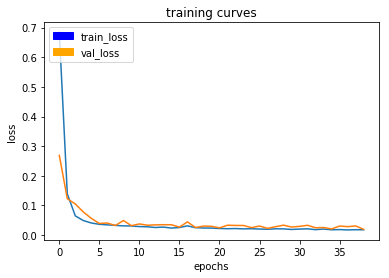

128/128 [==============================] - 55s - loss: 0.0181 - val_loss: 0.0195
Epoch 40/80
127/128 [============================>.] - ETA: 0s - loss: 0.0170

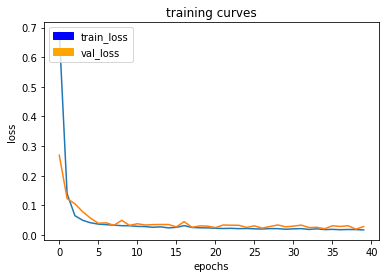

128/128 [==============================] - 55s - loss: 0.0170 - val_loss: 0.0283
Epoch 41/80
127/128 [============================>.] - ETA: 0s - loss: 0.0183

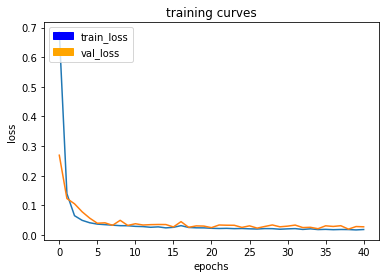

128/128 [==============================] - 55s - loss: 0.0183 - val_loss: 0.0274
Epoch 42/80
127/128 [============================>.] - ETA: 0s - loss: 0.0179

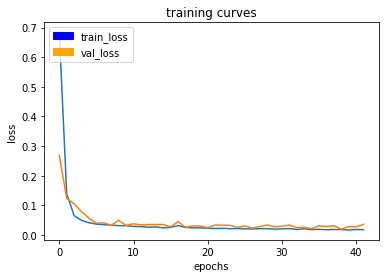

128/128 [==============================] - 55s - loss: 0.0179 - val_loss: 0.0361
Epoch 43/80
127/128 [============================>.] - ETA: 0s - loss: 0.0167

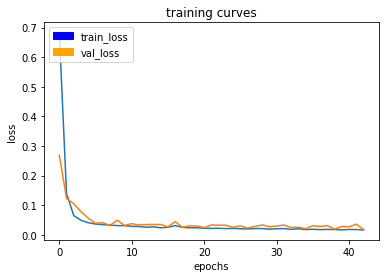

128/128 [==============================] - 55s - loss: 0.0166 - val_loss: 0.0180
Epoch 44/80
127/128 [============================>.] - ETA: 0s - loss: 0.0184

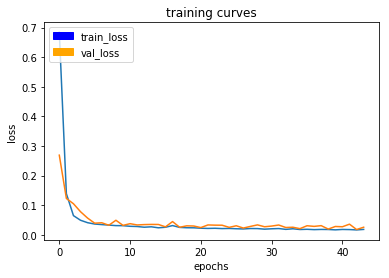

128/128 [==============================] - 55s - loss: 0.0184 - val_loss: 0.0258
Epoch 45/80
127/128 [============================>.] - ETA: 0s - loss: 0.0175

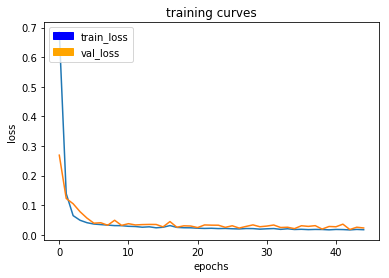

128/128 [==============================] - 55s - loss: 0.0175 - val_loss: 0.0233
Epoch 46/80
127/128 [============================>.] - ETA: 0s - loss: 0.0177

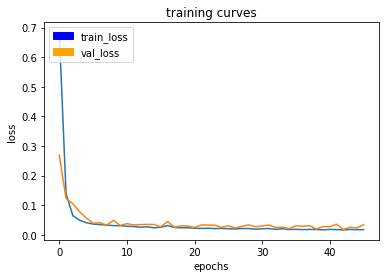

128/128 [==============================] - 55s - loss: 0.0177 - val_loss: 0.0346
Epoch 47/80
127/128 [============================>.] - ETA: 0s - loss: 0.0171

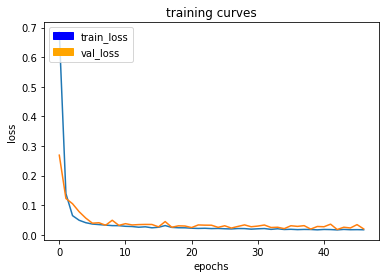

128/128 [==============================] - 55s - loss: 0.0171 - val_loss: 0.0200
Epoch 48/80
127/128 [============================>.] - ETA: 0s - loss: 0.0165

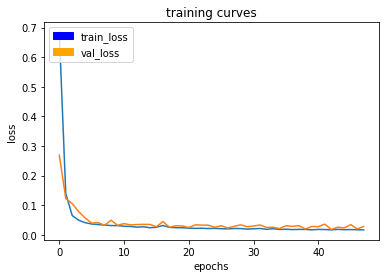

128/128 [==============================] - 55s - loss: 0.0165 - val_loss: 0.0281
Epoch 49/80
127/128 [============================>.] - ETA: 0s - loss: 0.0169

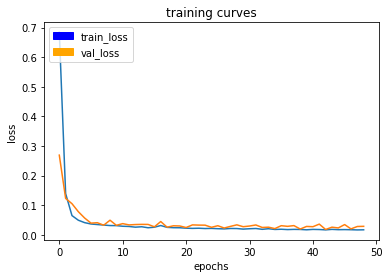

128/128 [==============================] - 55s - loss: 0.0169 - val_loss: 0.0286
Epoch 50/80
127/128 [============================>.] - ETA: 0s - loss: 0.0164

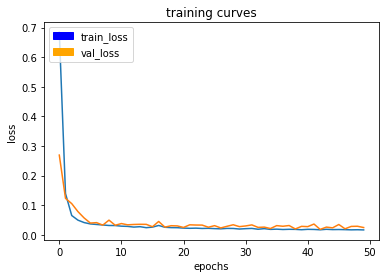

128/128 [==============================] - 55s - loss: 0.0164 - val_loss: 0.0243
Epoch 51/80
127/128 [============================>.] - ETA: 0s - loss: 0.0157

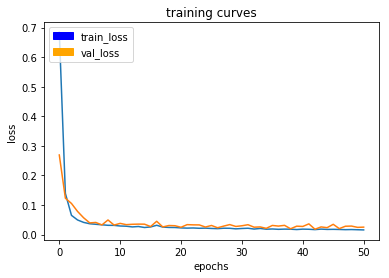

128/128 [==============================] - 55s - loss: 0.0157 - val_loss: 0.0250
Epoch 52/80
127/128 [============================>.] - ETA: 0s - loss: 0.0172

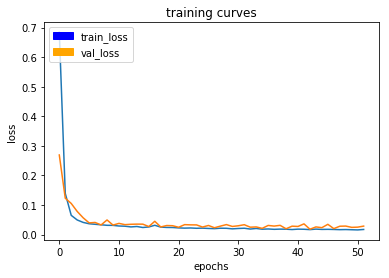

128/128 [==============================] - 55s - loss: 0.0172 - val_loss: 0.0285
Epoch 53/80
127/128 [============================>.] - ETA: 0s - loss: 0.0162

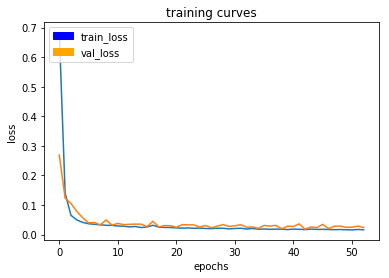

128/128 [==============================] - 55s - loss: 0.0162 - val_loss: 0.0240
Epoch 54/80
127/128 [============================>.] - ETA: 0s - loss: 0.0167

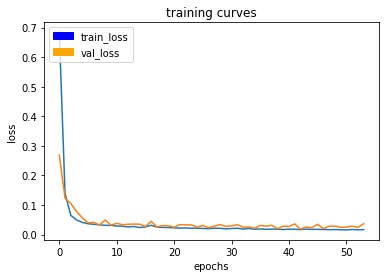

128/128 [==============================] - 55s - loss: 0.0167 - val_loss: 0.0367
Epoch 55/80
127/128 [============================>.] - ETA: 0s - loss: 0.0158

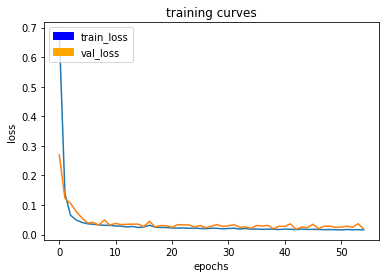

128/128 [==============================] - 55s - loss: 0.0157 - val_loss: 0.0189
Epoch 56/80
127/128 [============================>.] - ETA: 0s - loss: 0.0152

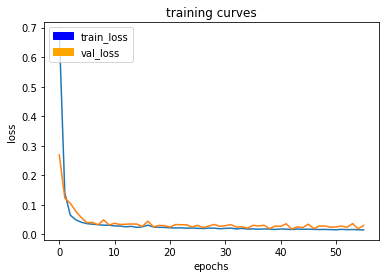

128/128 [==============================] - 55s - loss: 0.0152 - val_loss: 0.0303
Epoch 57/80
127/128 [============================>.] - ETA: 0s - loss: 0.0152

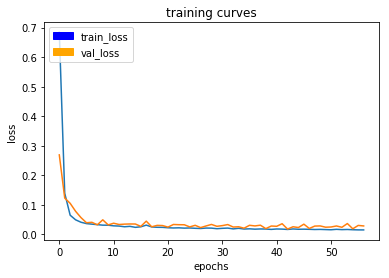

128/128 [==============================] - 54s - loss: 0.0151 - val_loss: 0.0286
Epoch 58/80
127/128 [============================>.] - ETA: 0s - loss: 0.0157

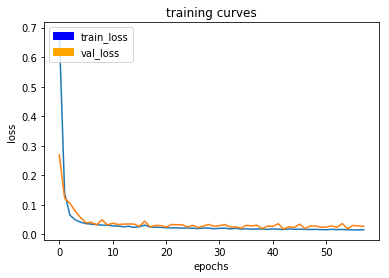

128/128 [==============================] - 55s - loss: 0.0157 - val_loss: 0.0277
Epoch 59/80
127/128 [============================>.] - ETA: 0s - loss: 0.0148

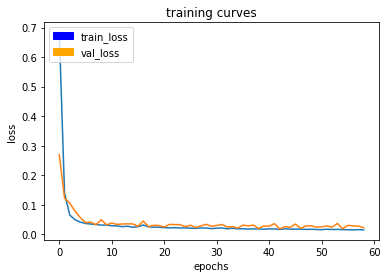

128/128 [==============================] - 55s - loss: 0.0148 - val_loss: 0.0225
Epoch 60/80
127/128 [============================>.] - ETA: 0s - loss: 0.0154

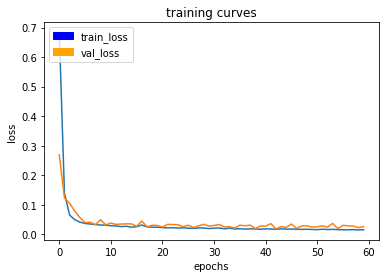

128/128 [==============================] - 55s - loss: 0.0154 - val_loss: 0.0263
Epoch 61/80
127/128 [============================>.] - ETA: 0s - loss: 0.0152

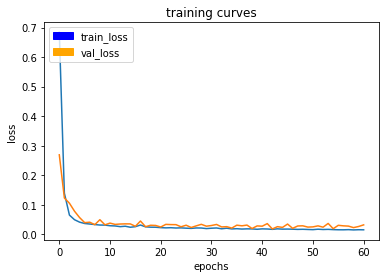

128/128 [==============================] - 55s - loss: 0.0151 - val_loss: 0.0318
Epoch 62/80
127/128 [============================>.] - ETA: 0s - loss: 0.0153

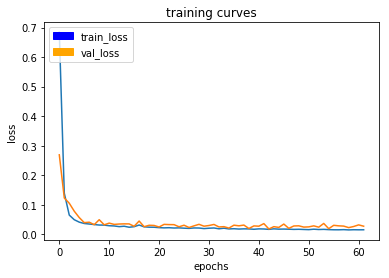

128/128 [==============================] - 55s - loss: 0.0153 - val_loss: 0.0273
Epoch 63/80
127/128 [============================>.] - ETA: 0s - loss: 0.0146

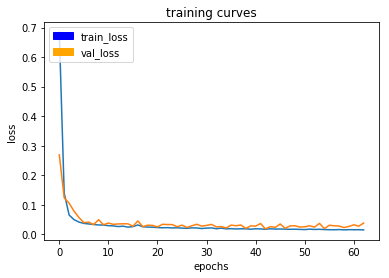

128/128 [==============================] - 55s - loss: 0.0146 - val_loss: 0.0378
Epoch 64/80
127/128 [============================>.] - ETA: 0s - loss: 0.0160

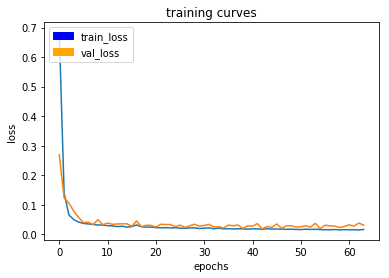

128/128 [==============================] - 55s - loss: 0.0160 - val_loss: 0.0304
Epoch 65/80
127/128 [============================>.] - ETA: 0s - loss: 0.0151

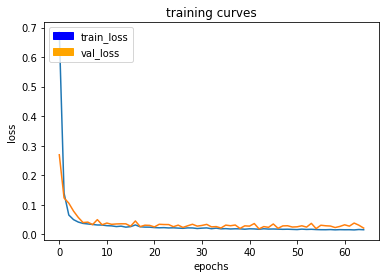

128/128 [==============================] - 55s - loss: 0.0152 - val_loss: 0.0207
Epoch 66/80
127/128 [============================>.] - ETA: 0s - loss: 0.0162

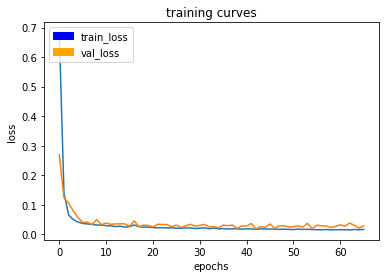

128/128 [==============================] - 55s - loss: 0.0162 - val_loss: 0.0282
Epoch 67/80
127/128 [============================>.] - ETA: 0s - loss: 0.0164

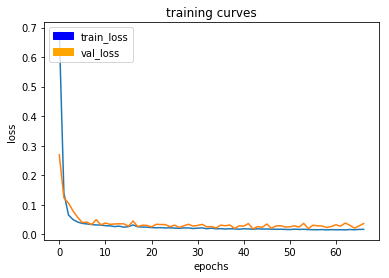

128/128 [==============================] - 55s - loss: 0.0164 - val_loss: 0.0360
Epoch 68/80
127/128 [============================>.] - ETA: 0s - loss: 0.0153

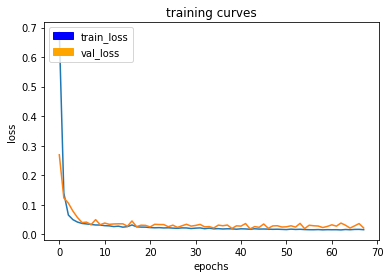

128/128 [==============================] - 55s - loss: 0.0152 - val_loss: 0.0210
Epoch 69/80
127/128 [============================>.] - ETA: 0s - loss: 0.0138

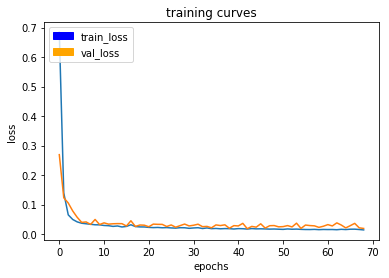

128/128 [==============================] - 55s - loss: 0.0138 - val_loss: 0.0188
Epoch 70/80
127/128 [============================>.] - ETA: 0s - loss: 0.0149

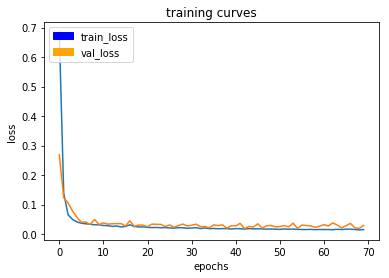

128/128 [==============================] - 55s - loss: 0.0149 - val_loss: 0.0292
Epoch 71/80
127/128 [============================>.] - ETA: 0s - loss: 0.0136

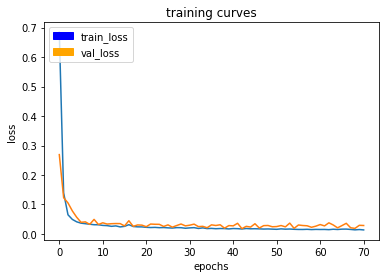

128/128 [==============================] - 55s - loss: 0.0136 - val_loss: 0.0286
Epoch 72/80
127/128 [============================>.] - ETA: 0s - loss: 0.0136

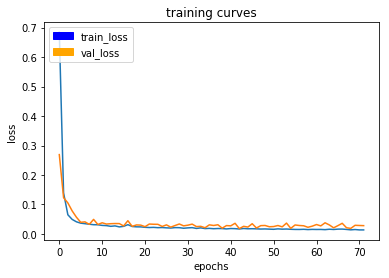

128/128 [==============================] - 55s - loss: 0.0136 - val_loss: 0.0281
Epoch 73/80
 63/128 [=============>................] - ETA: 23s - loss: 0.0133

In [ ]:
# Run One
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

learning_rate = 0.001
batch_size = 32
num_epochs = 80
steps_per_epoch = int(4131/batch_size)-1#200
validation_steps = int(1000/batch_size)-1
workers = 1 # Using GPU.
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

# Save your trained model weights
weight_file_name = 'model_weights-lr001ep80'
model_tools.save_network(model, weight_file_name)
score_all()

Feature layer (?, 160, 160, 3)
Encoder 1 (?, 80, 80, 32)
Encoder 2 (?, 40, 40, 64)
Encoder 3 (?, 20, 20, 128)
1x1 Conv (?, 20, 20, 128)
Decoder 1 (?, 40, 40, 128)
Decoder 2 (?, 80, 80, 64)
Decoder 3 (?, 160, 160, 32)
Output_layer (?, 160, 160, 3)
Epoch 1/80
127/128 [============================>.] - ETA: 0s - loss: 0.6880

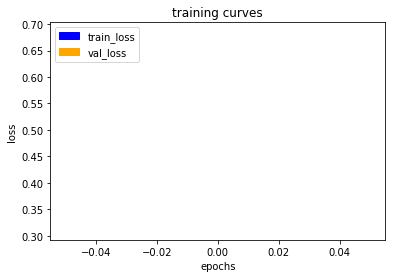

128/128 [==============================] - 58s - loss: 0.6847 - val_loss: 0.3110
Epoch 2/80
127/128 [============================>.] - ETA: 0s - loss: 0.1400

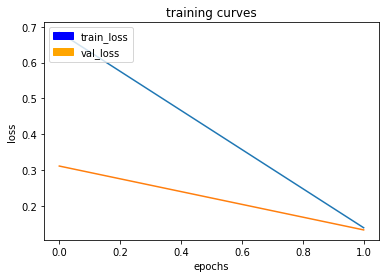

128/128 [==============================] - 54s - loss: 0.1395 - val_loss: 0.1327
Epoch 3/80
127/128 [============================>.] - ETA: 0s - loss: 0.0657

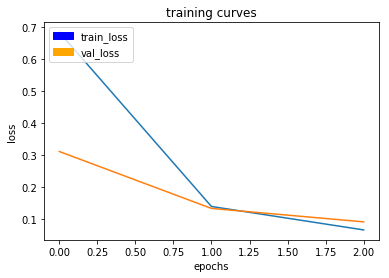

128/128 [==============================] - 55s - loss: 0.0656 - val_loss: 0.0906
Epoch 4/80
127/128 [============================>.] - ETA: 0s - loss: 0.0493

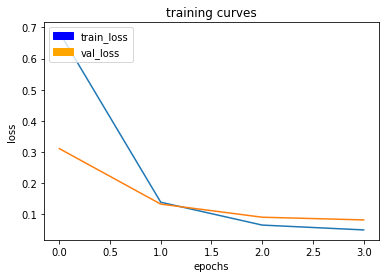

128/128 [==============================] - 54s - loss: 0.0498 - val_loss: 0.0820
Epoch 5/80
127/128 [============================>.] - ETA: 0s - loss: 0.0418

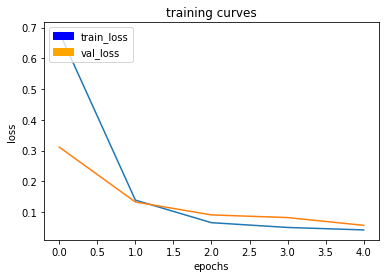

128/128 [==============================] - 54s - loss: 0.0418 - val_loss: 0.0567
Epoch 6/80
127/128 [============================>.] - ETA: 0s - loss: 0.0389

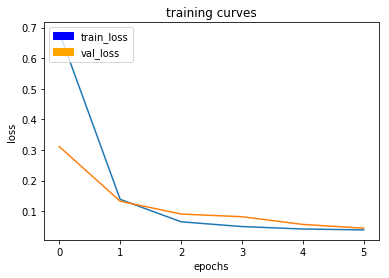

128/128 [==============================] - 54s - loss: 0.0389 - val_loss: 0.0445
Epoch 7/80
127/128 [============================>.] - ETA: 0s - loss: 0.0356

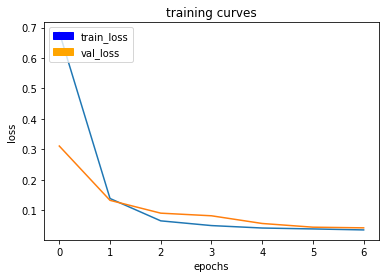

128/128 [==============================] - 54s - loss: 0.0356 - val_loss: 0.0424
Epoch 8/80
127/128 [============================>.] - ETA: 0s - loss: 0.0335

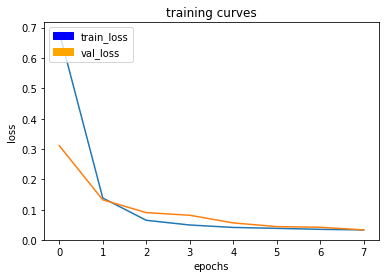

128/128 [==============================] - 54s - loss: 0.0336 - val_loss: 0.0337
Epoch 9/80
127/128 [============================>.] - ETA: 0s - loss: 0.0317

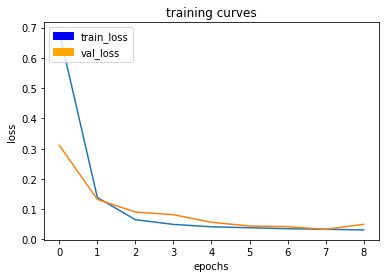

128/128 [==============================] - 54s - loss: 0.0317 - val_loss: 0.0501
Epoch 10/80
127/128 [============================>.] - ETA: 0s - loss: 0.0299

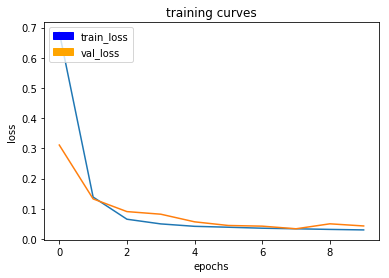

128/128 [==============================] - 54s - loss: 0.0299 - val_loss: 0.0430
Epoch 11/80
127/128 [============================>.] - ETA: 0s - loss: 0.0287

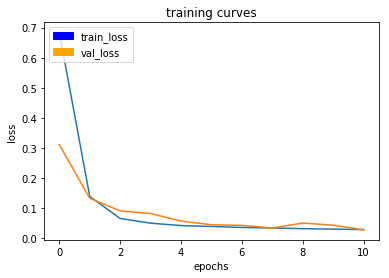

128/128 [==============================] - 54s - loss: 0.0287 - val_loss: 0.0273
Epoch 12/80
127/128 [============================>.] - ETA: 0s - loss: 0.0290

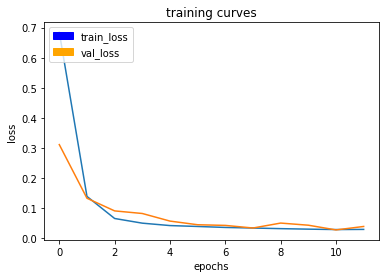

128/128 [==============================] - 54s - loss: 0.0290 - val_loss: 0.0388
Epoch 13/80
127/128 [============================>.] - ETA: 0s - loss: 0.0257

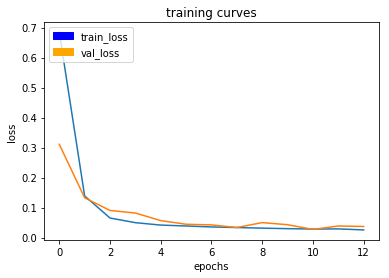

128/128 [==============================] - 54s - loss: 0.0257 - val_loss: 0.0371
Epoch 14/80
127/128 [============================>.] - ETA: 0s - loss: 0.0286

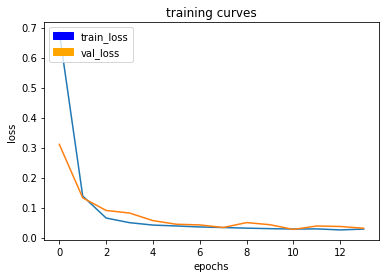

128/128 [==============================] - 54s - loss: 0.0285 - val_loss: 0.0312
Epoch 15/80
127/128 [============================>.] - ETA: 0s - loss: 0.0268

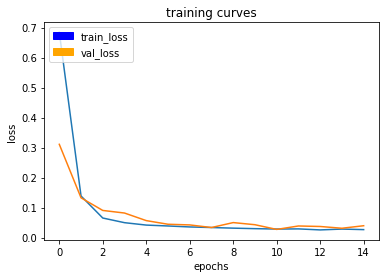

128/128 [==============================] - 54s - loss: 0.0268 - val_loss: 0.0396
Epoch 16/80
127/128 [============================>.] - ETA: 0s - loss: 0.0258

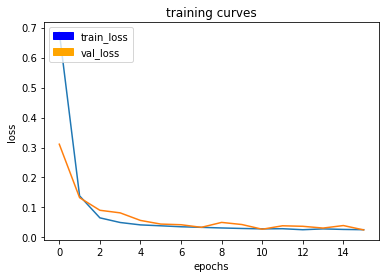

128/128 [==============================] - 54s - loss: 0.0258 - val_loss: 0.0250
Epoch 17/80
127/128 [============================>.] - ETA: 0s - loss: 0.0235

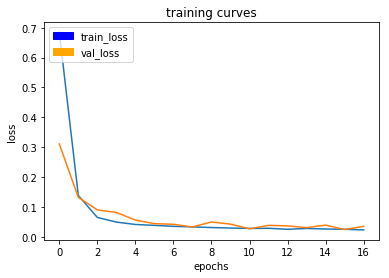

128/128 [==============================] - 54s - loss: 0.0235 - val_loss: 0.0354
Epoch 18/80
127/128 [============================>.] - ETA: 0s - loss: 0.0240

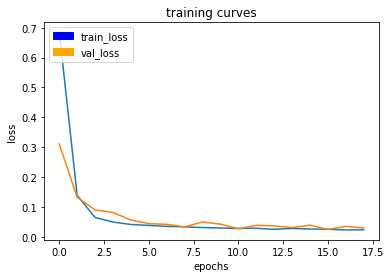

128/128 [==============================] - 54s - loss: 0.0239 - val_loss: 0.0302
Epoch 19/80
127/128 [============================>.] - ETA: 0s - loss: 0.0240

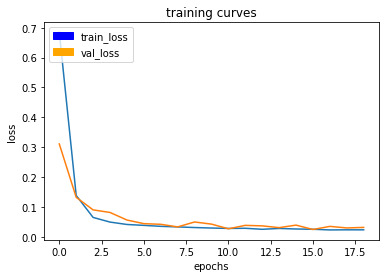

128/128 [==============================] - 54s - loss: 0.0239 - val_loss: 0.0319
Epoch 20/80
127/128 [============================>.] - ETA: 0s - loss: 0.0241

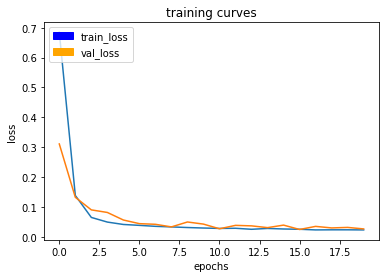

128/128 [==============================] - 54s - loss: 0.0241 - val_loss: 0.0269
Epoch 21/80
127/128 [============================>.] - ETA: 0s - loss: 0.0235

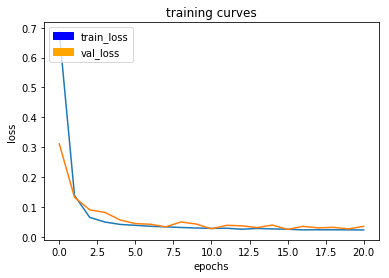

128/128 [==============================] - 55s - loss: 0.0235 - val_loss: 0.0353
Epoch 22/80
127/128 [============================>.] - ETA: 0s - loss: 0.0213

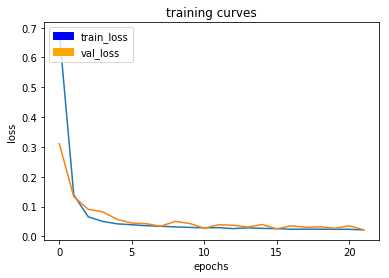

128/128 [==============================] - 54s - loss: 0.0215 - val_loss: 0.0217
Epoch 23/80
127/128 [============================>.] - ETA: 0s - loss: 0.0229

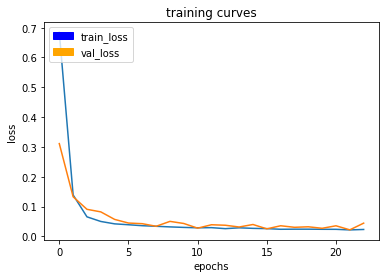

128/128 [==============================] - 54s - loss: 0.0230 - val_loss: 0.0441
Epoch 24/80
127/128 [============================>.] - ETA: 0s - loss: 0.0196

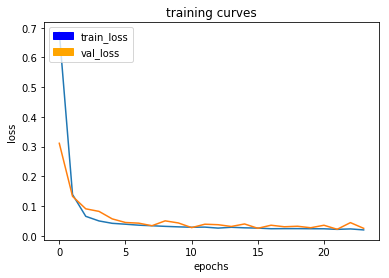

128/128 [==============================] - 54s - loss: 0.0196 - val_loss: 0.0249
Epoch 25/80
127/128 [============================>.] - ETA: 0s - loss: 0.0224

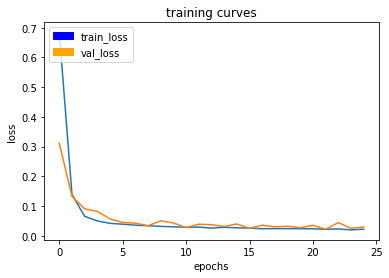

128/128 [==============================] - 54s - loss: 0.0224 - val_loss: 0.0296
Epoch 26/80
127/128 [============================>.] - ETA: 0s - loss: 0.0219

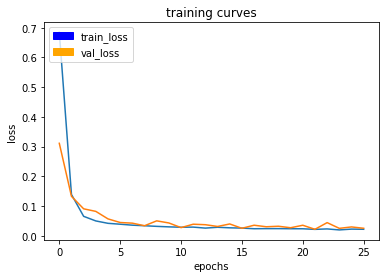

128/128 [==============================] - 54s - loss: 0.0218 - val_loss: 0.0252
Epoch 27/80
127/128 [============================>.] - ETA: 0s - loss: 0.0214

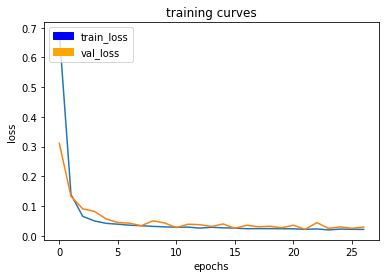

128/128 [==============================] - 54s - loss: 0.0213 - val_loss: 0.0292
Epoch 28/80
127/128 [============================>.] - ETA: 0s - loss: 0.0209

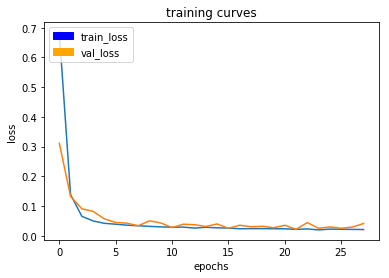

128/128 [==============================] - 54s - loss: 0.0209 - val_loss: 0.0412
Epoch 29/80
127/128 [============================>.] - ETA: 0s - loss: 0.0197

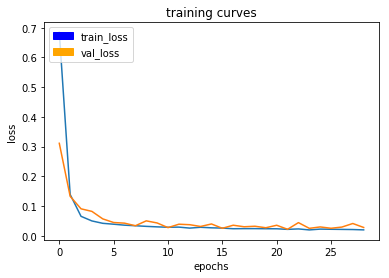

128/128 [==============================] - 54s - loss: 0.0197 - val_loss: 0.0279
Epoch 30/80
127/128 [============================>.] - ETA: 0s - loss: 0.0199

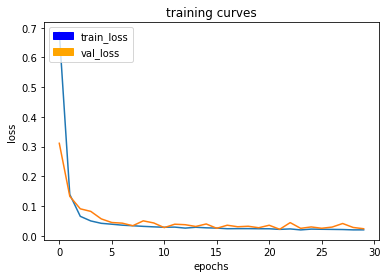

128/128 [==============================] - 54s - loss: 0.0199 - val_loss: 0.0236
Epoch 31/80
127/128 [============================>.] - ETA: 0s - loss: 0.0197

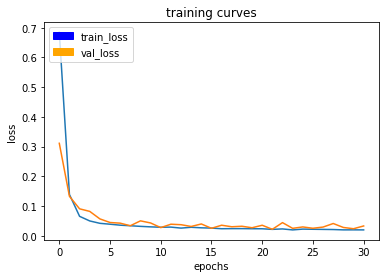

128/128 [==============================] - 54s - loss: 0.0197 - val_loss: 0.0329
Epoch 32/80
127/128 [============================>.] - ETA: 0s - loss: 0.0202

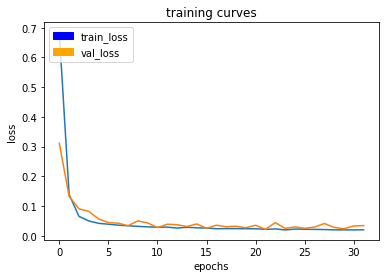

128/128 [==============================] - 54s - loss: 0.0202 - val_loss: 0.0342
Epoch 33/80
127/128 [============================>.] - ETA: 0s - loss: 0.0205

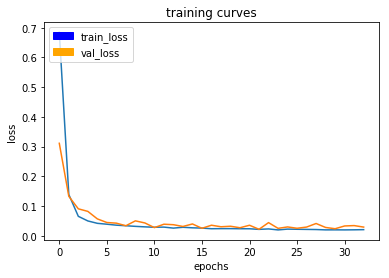

128/128 [==============================] - 54s - loss: 0.0204 - val_loss: 0.0291
Epoch 34/80
127/128 [============================>.] - ETA: 0s - loss: 0.0190

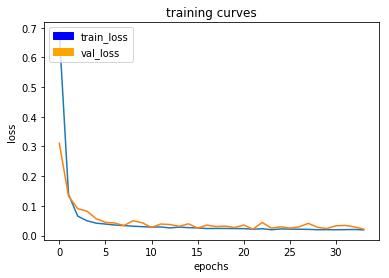

128/128 [==============================] - 54s - loss: 0.0190 - val_loss: 0.0219
Epoch 35/80
127/128 [============================>.] - ETA: 0s - loss: 0.0181

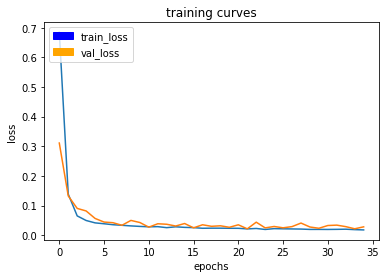

128/128 [==============================] - 54s - loss: 0.0181 - val_loss: 0.0284
Epoch 36/80
127/128 [============================>.] - ETA: 0s - loss: 0.0190

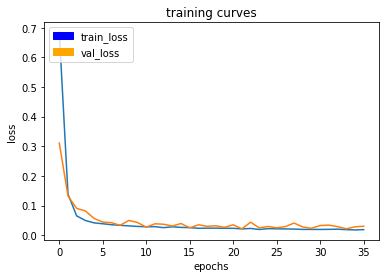

128/128 [==============================] - 54s - loss: 0.0190 - val_loss: 0.0304
Epoch 37/80
127/128 [============================>.] - ETA: 0s - loss: 0.0183

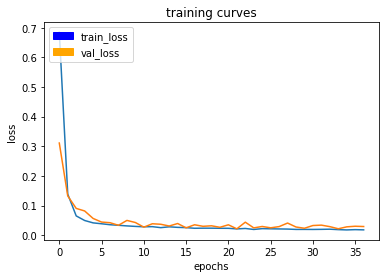

128/128 [==============================] - 54s - loss: 0.0183 - val_loss: 0.0295
Epoch 38/80
127/128 [============================>.] - ETA: 0s - loss: 0.0186

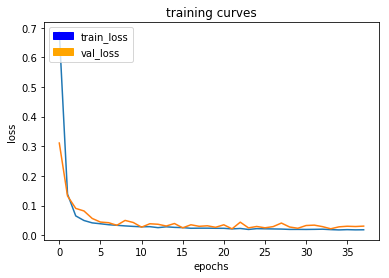

128/128 [==============================] - 54s - loss: 0.0186 - val_loss: 0.0308
Epoch 39/80
127/128 [============================>.] - ETA: 0s - loss: 0.0184

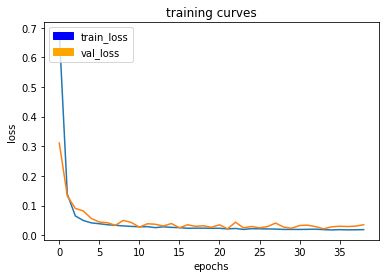

128/128 [==============================] - 54s - loss: 0.0189 - val_loss: 0.0356
Epoch 40/80
127/128 [============================>.] - ETA: 0s - loss: 0.0200

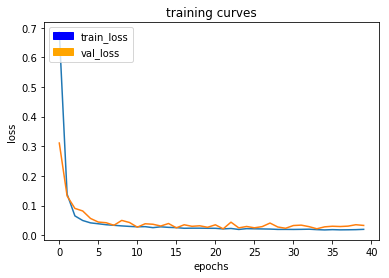

128/128 [==============================] - 54s - loss: 0.0200 - val_loss: 0.0332
Epoch 41/80
127/128 [============================>.] - ETA: 0s - loss: 0.0177

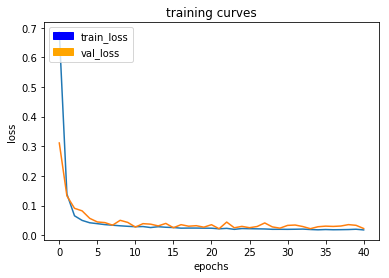

128/128 [==============================] - 54s - loss: 0.0177 - val_loss: 0.0224
Epoch 42/80
127/128 [============================>.] - ETA: 0s - loss: 0.0181

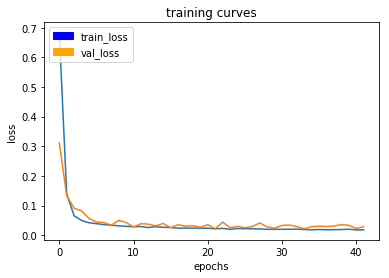

128/128 [==============================] - 54s - loss: 0.0180 - val_loss: 0.0283
Epoch 43/80
127/128 [============================>.] - ETA: 0s - loss: 0.0171

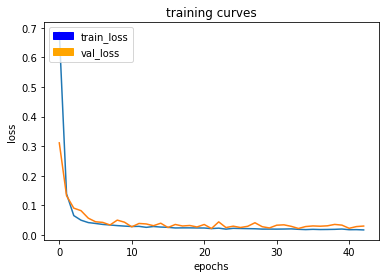

128/128 [==============================] - 54s - loss: 0.0171 - val_loss: 0.0300
Epoch 44/80
127/128 [============================>.] - ETA: 0s - loss: 0.0169

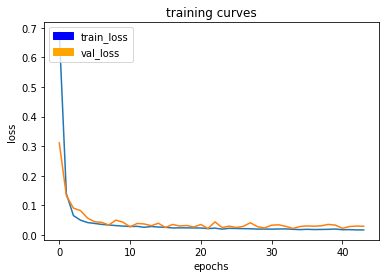

128/128 [==============================] - 54s - loss: 0.0169 - val_loss: 0.0293
Epoch 45/80
127/128 [============================>.] - ETA: 0s - loss: 0.0178

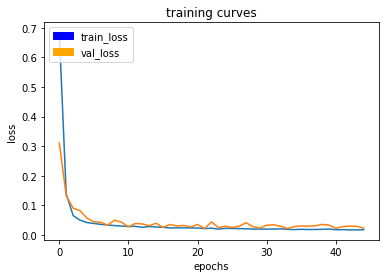

128/128 [==============================] - 54s - loss: 0.0178 - val_loss: 0.0229
Epoch 46/80
127/128 [============================>.] - ETA: 0s - loss: 0.0170

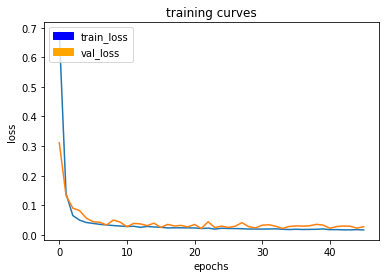

128/128 [==============================] - 54s - loss: 0.0169 - val_loss: 0.0276
Epoch 47/80
127/128 [============================>.] - ETA: 0s - loss: 0.0173

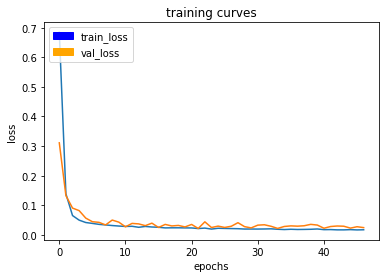

128/128 [==============================] - 54s - loss: 0.0173 - val_loss: 0.0246
Epoch 48/80
127/128 [============================>.] - ETA: 0s - loss: 0.0179

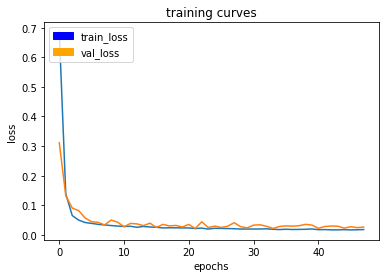

128/128 [==============================] - 54s - loss: 0.0179 - val_loss: 0.0263
Epoch 49/80
127/128 [============================>.] - ETA: 0s - loss: 0.0159

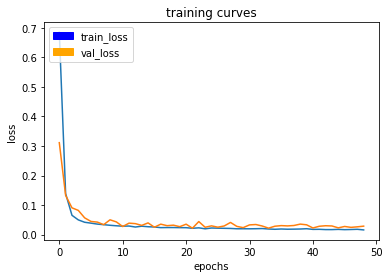

128/128 [==============================] - 55s - loss: 0.0159 - val_loss: 0.0286
Epoch 50/80
127/128 [============================>.] - ETA: 0s - loss: 0.0162

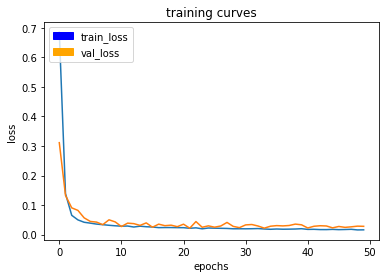

128/128 [==============================] - 54s - loss: 0.0162 - val_loss: 0.0281
Epoch 51/80
127/128 [============================>.] - ETA: 0s - loss: 0.0163

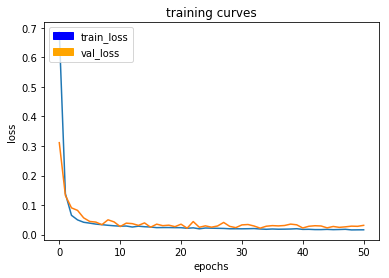

128/128 [==============================] - 54s - loss: 0.0162 - val_loss: 0.0314
Epoch 52/80
127/128 [============================>.] - ETA: 0s - loss: 0.0173

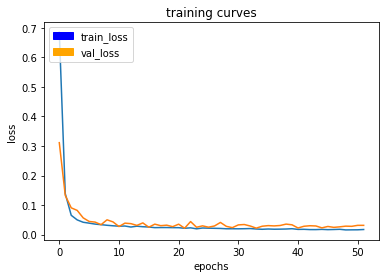

128/128 [==============================] - 54s - loss: 0.0173 - val_loss: 0.0314
Epoch 53/80
  2/128 [..............................] - ETA: 45s - loss: 0.0177

In [ ]:
# Run One
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

learning_rate = 0.001
batch_size = 32
num_epochs = 80
steps_per_epoch = int(4131/batch_size)-1#200
validation_steps = int(1000/batch_size)-1
workers = 1 # Using GPU.
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

# Save your trained model weights
weight_file_name = 'model_weights-lr001ep80'
model_tools.save_network(model, weight_file_name)
score_all()

In [9]:
weight_file_name = 'model_weights-lr001ep80'
model_tools.save_network(model, weight_file_name)
score_all()

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9952818098013742
average intersection over union for other people is 0.3475127989407102
average intersection over union for the hero is 0.89822017467698
number true positives: 539, number false positives: 0, number false negatives: 0
number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.984562128278374
average intersection over union for other people is 0.6868302120677434
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 52, number false negatives: 0
number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9959821475895548
average intersection over union for other people is 0.42966077806067465
average intersection over union for the hero is 0.18309341584095531
number true 

Feature layer (?, 160, 160, 3)
Encoder 1 (?, 80, 80, 32)
Encoder 2 (?, 40, 40, 64)
Encoder 3 (?, 20, 20, 128)
1x1 Conv (?, 20, 20, 128)
Decoder 1 (?, 40, 40, 128)
Decoder 2 (?, 80, 80, 64)
Decoder 3 (?, 160, 160, 32)
Output_layer (?, 160, 160, 3)
Epoch 1/80
127/128 [============================>.] - ETA: 0s - loss: 0.7026

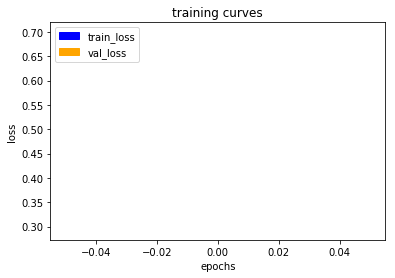

128/128 [==============================] - 55s - loss: 0.6994 - val_loss: 0.2932
Epoch 2/80
127/128 [============================>.] - ETA: 0s - loss: 0.1472

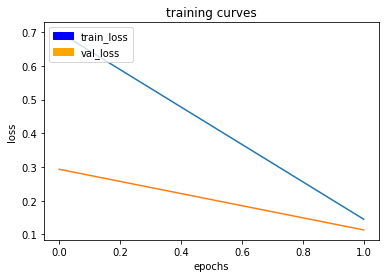

128/128 [==============================] - 54s - loss: 0.1470 - val_loss: 0.1135
Epoch 3/80
127/128 [============================>.] - ETA: 0s - loss: 0.0740

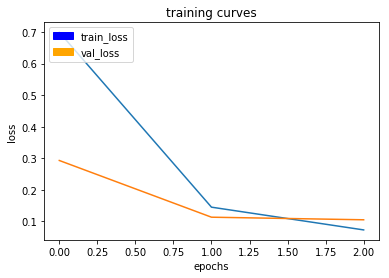

128/128 [==============================] - 54s - loss: 0.0739 - val_loss: 0.1053
Epoch 4/80
127/128 [============================>.] - ETA: 0s - loss: 0.0531

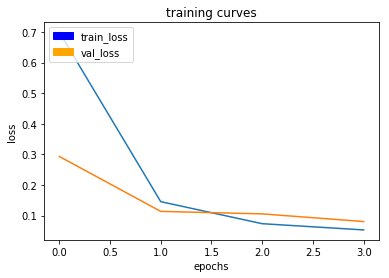

128/128 [==============================] - 54s - loss: 0.0530 - val_loss: 0.0803
Epoch 5/80
127/128 [============================>.] - ETA: 0s - loss: 0.0437

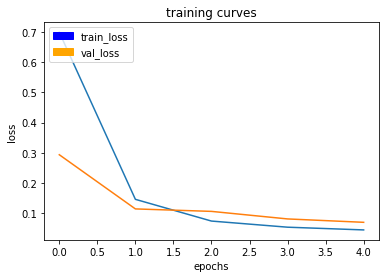

128/128 [==============================] - 54s - loss: 0.0438 - val_loss: 0.0691
Epoch 6/80
127/128 [============================>.] - ETA: 0s - loss: 0.0399

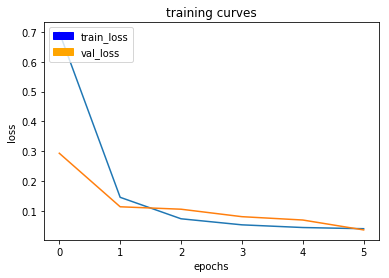

128/128 [==============================] - 54s - loss: 0.0399 - val_loss: 0.0358
Epoch 7/80
127/128 [============================>.] - ETA: 0s - loss: 0.0362

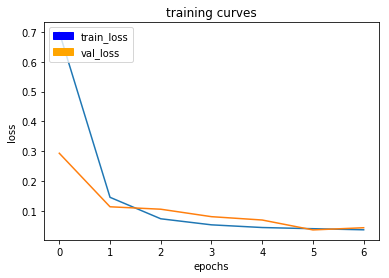

128/128 [==============================] - 54s - loss: 0.0362 - val_loss: 0.0432
Epoch 8/80
127/128 [============================>.] - ETA: 0s - loss: 0.0332

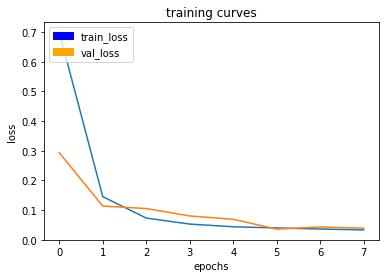

128/128 [==============================] - 54s - loss: 0.0332 - val_loss: 0.0391
Epoch 9/80
127/128 [============================>.] - ETA: 0s - loss: 0.0329

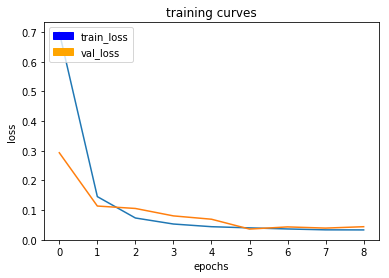

128/128 [==============================] - 54s - loss: 0.0330 - val_loss: 0.0438
Epoch 10/80
127/128 [============================>.] - ETA: 0s - loss: 0.0308

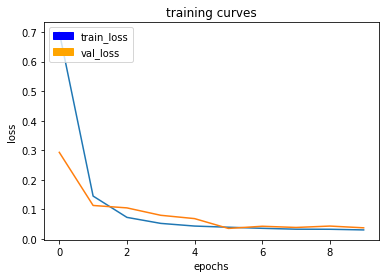

128/128 [==============================] - 54s - loss: 0.0307 - val_loss: 0.0379
Epoch 11/80
127/128 [============================>.] - ETA: 0s - loss: 0.0303

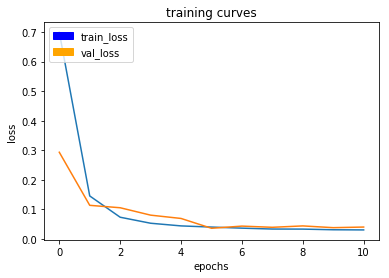

128/128 [==============================] - 54s - loss: 0.0302 - val_loss: 0.0400
Epoch 12/80
127/128 [============================>.] - ETA: 0s - loss: 0.0277

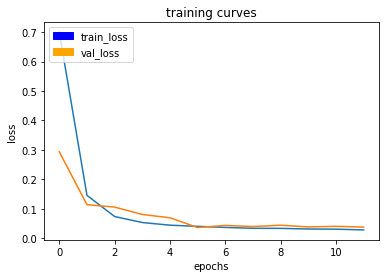

128/128 [==============================] - 54s - loss: 0.0277 - val_loss: 0.0373
Epoch 13/80
127/128 [============================>.] - ETA: 0s - loss: 0.0281

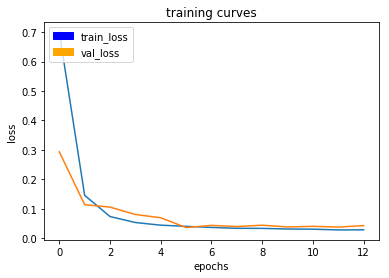

128/128 [==============================] - 54s - loss: 0.0281 - val_loss: 0.0425
Epoch 14/80
127/128 [============================>.] - ETA: 0s - loss: 0.0335

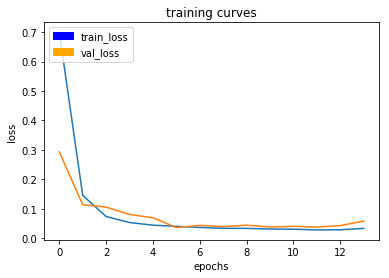

128/128 [==============================] - 54s - loss: 0.0334 - val_loss: 0.0579
Epoch 15/80
127/128 [============================>.] - ETA: 0s - loss: 0.0278

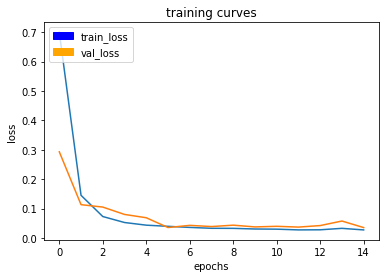

128/128 [==============================] - 54s - loss: 0.0277 - val_loss: 0.0357
Epoch 16/80
127/128 [============================>.] - ETA: 0s - loss: 0.0276

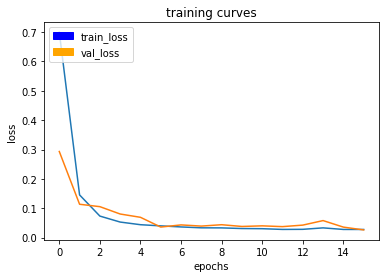

128/128 [==============================] - 54s - loss: 0.0276 - val_loss: 0.0261
Epoch 17/80
127/128 [============================>.] - ETA: 0s - loss: 0.0259

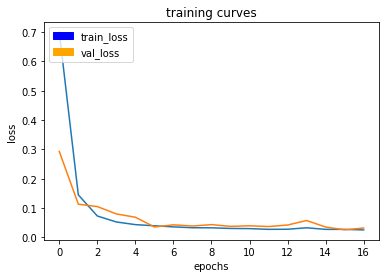

128/128 [==============================] - 54s - loss: 0.0258 - val_loss: 0.0324
Epoch 18/80
127/128 [============================>.] - ETA: 0s - loss: 0.0262

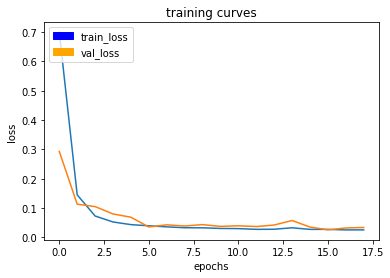

128/128 [==============================] - 54s - loss: 0.0261 - val_loss: 0.0341
Epoch 19/80
127/128 [============================>.] - ETA: 0s - loss: 0.0242

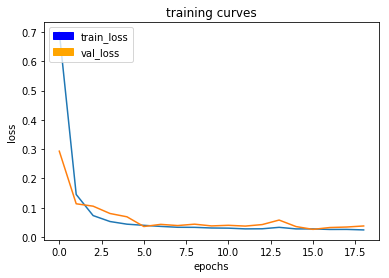

128/128 [==============================] - 54s - loss: 0.0242 - val_loss: 0.0377
Epoch 20/80
127/128 [============================>.] - ETA: 0s - loss: 0.0240

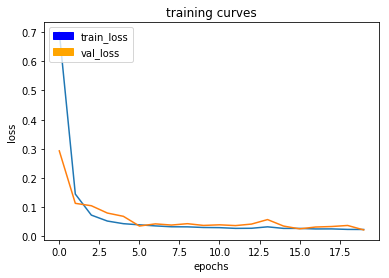

128/128 [==============================] - 54s - loss: 0.0240 - val_loss: 0.0225
Epoch 21/80
127/128 [============================>.] - ETA: 0s - loss: 0.0232

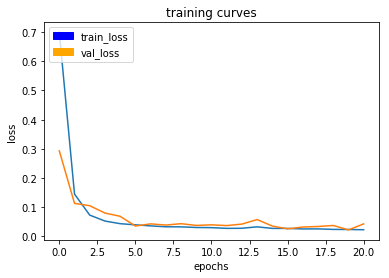

128/128 [==============================] - 54s - loss: 0.0232 - val_loss: 0.0431
Epoch 22/80
127/128 [============================>.] - ETA: 0s - loss: 0.0228

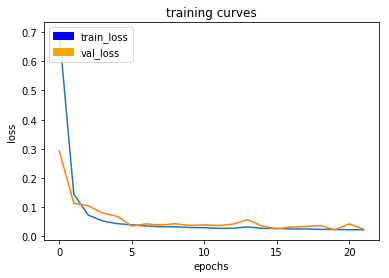

128/128 [==============================] - 54s - loss: 0.0229 - val_loss: 0.0251
Epoch 23/80
127/128 [============================>.] - ETA: 0s - loss: 0.0237

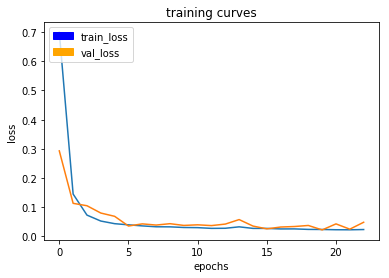

128/128 [==============================] - 54s - loss: 0.0238 - val_loss: 0.0487
Epoch 24/80
127/128 [============================>.] - ETA: 0s - loss: 0.0232

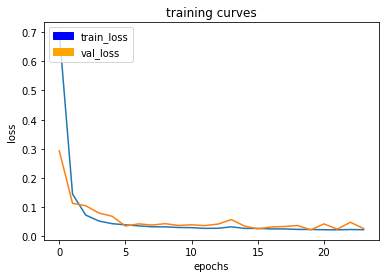

128/128 [==============================] - 54s - loss: 0.0232 - val_loss: 0.0272
Epoch 25/80
127/128 [============================>.] - ETA: 0s - loss: 0.0222

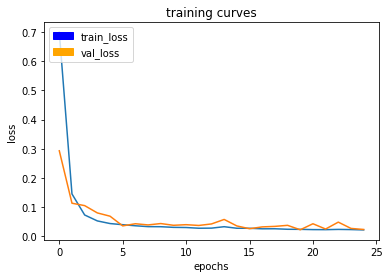

128/128 [==============================] - 54s - loss: 0.0222 - val_loss: 0.0236
Epoch 26/80
127/128 [============================>.] - ETA: 0s - loss: 0.0239

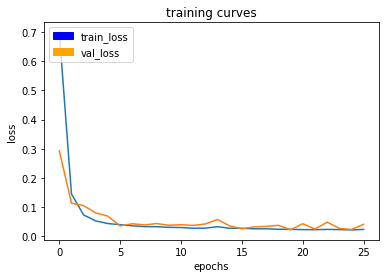

128/128 [==============================] - 54s - loss: 0.0238 - val_loss: 0.0413
Epoch 27/80
127/128 [============================>.] - ETA: 0s - loss: 0.0204

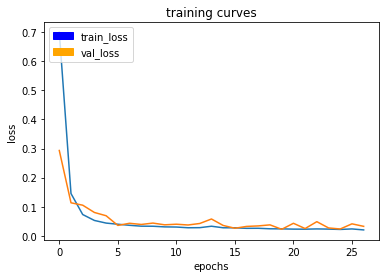

128/128 [==============================] - 54s - loss: 0.0204 - val_loss: 0.0326
Epoch 28/80
127/128 [============================>.] - ETA: 0s - loss: 0.0219

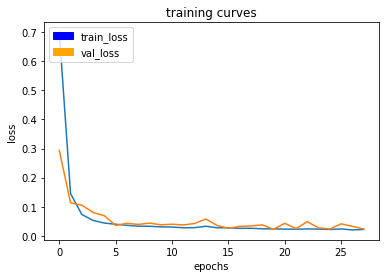

128/128 [==============================] - 54s - loss: 0.0219 - val_loss: 0.0235
Epoch 29/80
127/128 [============================>.] - ETA: 0s - loss: 0.0206

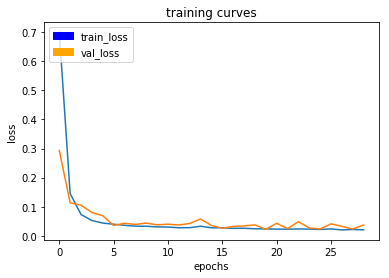

128/128 [==============================] - 54s - loss: 0.0206 - val_loss: 0.0374
Epoch 30/80
127/128 [============================>.] - ETA: 0s - loss: 0.0211

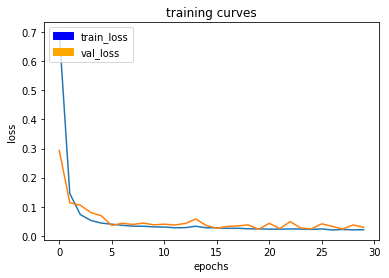

128/128 [==============================] - 54s - loss: 0.0211 - val_loss: 0.0295
Epoch 31/80
127/128 [============================>.] - ETA: 0s - loss: 0.0198

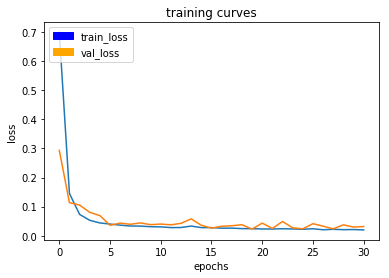

128/128 [==============================] - 54s - loss: 0.0198 - val_loss: 0.0314
Epoch 32/80
127/128 [============================>.] - ETA: 0s - loss: 0.0210

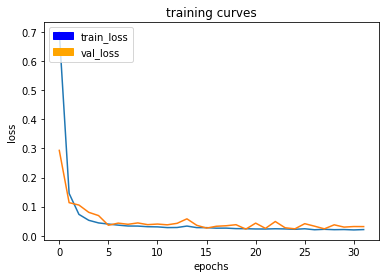

128/128 [==============================] - 53s - loss: 0.0210 - val_loss: 0.0312
Epoch 33/80
127/128 [============================>.] - ETA: 0s - loss: 0.0198

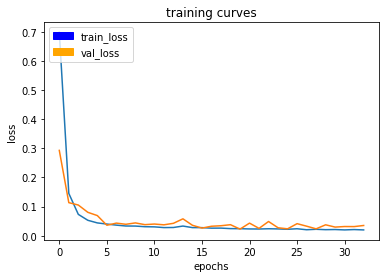

128/128 [==============================] - 54s - loss: 0.0198 - val_loss: 0.0350
Epoch 34/80
127/128 [============================>.] - ETA: 0s - loss: 0.0228

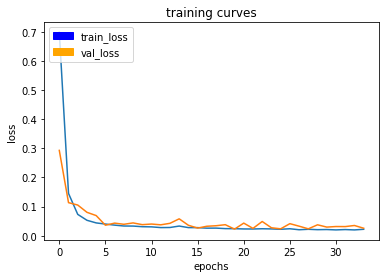

128/128 [==============================] - 54s - loss: 0.0228 - val_loss: 0.0256
Epoch 35/80
127/128 [============================>.] - ETA: 0s - loss: 0.0201

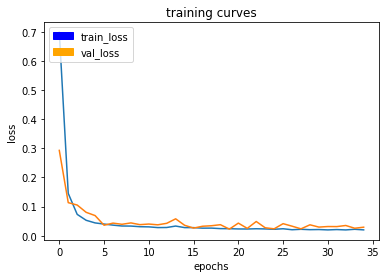

128/128 [==============================] - 54s - loss: 0.0201 - val_loss: 0.0291
Epoch 36/80
127/128 [============================>.] - ETA: 0s - loss: 0.0188

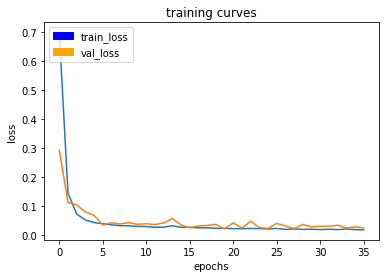

128/128 [==============================] - 54s - loss: 0.0188 - val_loss: 0.0254
Epoch 37/80
127/128 [============================>.] - ETA: 0s - loss: 0.0194

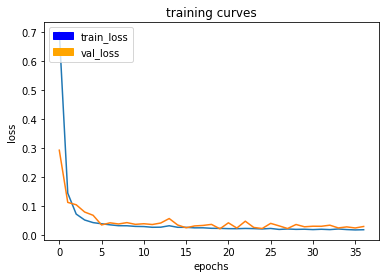

128/128 [==============================] - 54s - loss: 0.0194 - val_loss: 0.0305
Epoch 38/80
127/128 [============================>.] - ETA: 0s - loss: 0.0182

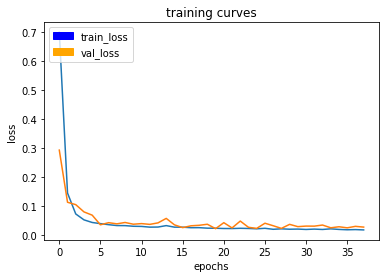

128/128 [==============================] - 54s - loss: 0.0182 - val_loss: 0.0279
Epoch 39/80
127/128 [============================>.] - ETA: 0s - loss: 0.0209

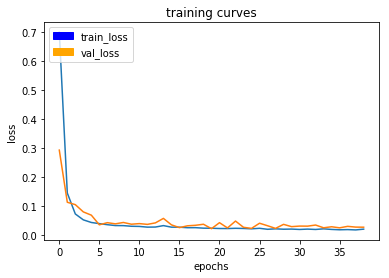

128/128 [==============================] - 54s - loss: 0.0208 - val_loss: 0.0276
Epoch 40/80
127/128 [============================>.] - ETA: 0s - loss: 0.0175

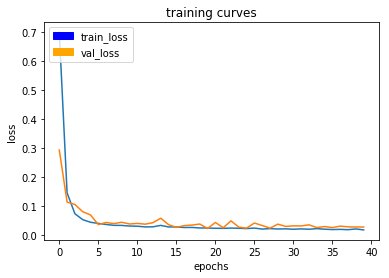

128/128 [==============================] - 54s - loss: 0.0175 - val_loss: 0.0275
Epoch 41/80
127/128 [============================>.] - ETA: 0s - loss: 0.0179

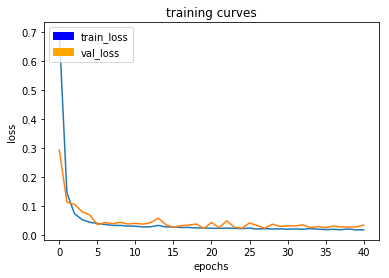

128/128 [==============================] - 54s - loss: 0.0179 - val_loss: 0.0341
Epoch 42/80
127/128 [============================>.] - ETA: 0s - loss: 0.0191

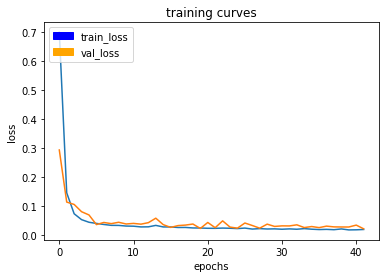

128/128 [==============================] - 54s - loss: 0.0191 - val_loss: 0.0213
Epoch 43/80
127/128 [============================>.] - ETA: 0s - loss: 0.0171

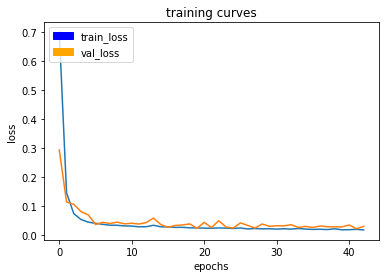

128/128 [==============================] - 54s - loss: 0.0171 - val_loss: 0.0293
Epoch 44/80
127/128 [============================>.] - ETA: 0s - loss: 0.0186

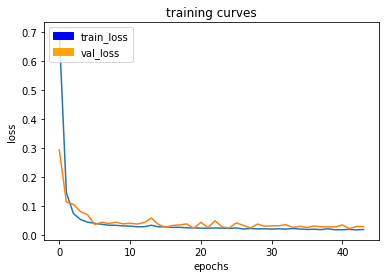

128/128 [==============================] - 54s - loss: 0.0187 - val_loss: 0.0281
Epoch 45/80
127/128 [============================>.] - ETA: 0s - loss: 0.0196

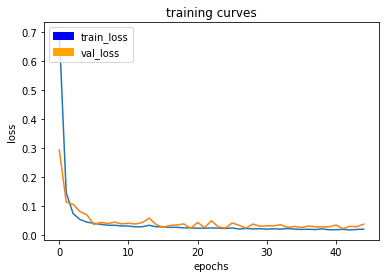

128/128 [==============================] - 54s - loss: 0.0197 - val_loss: 0.0370
Epoch 46/80
127/128 [============================>.] - ETA: 0s - loss: 0.0171

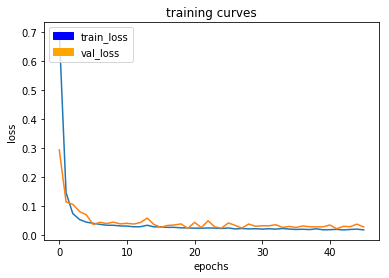

128/128 [==============================] - 54s - loss: 0.0171 - val_loss: 0.0273
Epoch 47/80
127/128 [============================>.] - ETA: 0s - loss: 0.0174

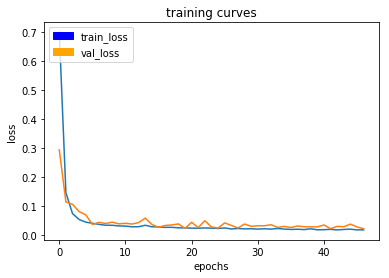

128/128 [==============================] - 54s - loss: 0.0174 - val_loss: 0.0210
Epoch 48/80
127/128 [============================>.] - ETA: 0s - loss: 0.0176

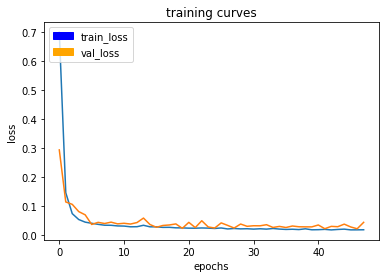

128/128 [==============================] - 54s - loss: 0.0176 - val_loss: 0.0432
Epoch 49/80
127/128 [============================>.] - ETA: 0s - loss: 0.0189

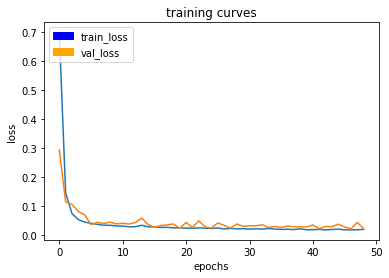

128/128 [==============================] - 54s - loss: 0.0189 - val_loss: 0.0211
Epoch 50/80
127/128 [============================>.] - ETA: 0s - loss: 0.0175

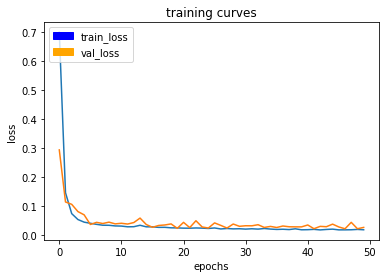

128/128 [==============================] - 54s - loss: 0.0175 - val_loss: 0.0257
Epoch 51/80
127/128 [============================>.] - ETA: 0s - loss: 0.0163

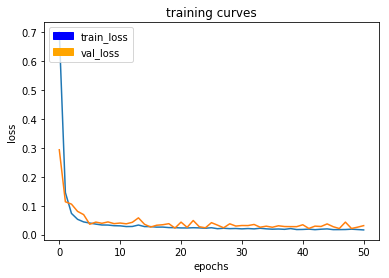

128/128 [==============================] - 54s - loss: 0.0163 - val_loss: 0.0310
Epoch 52/80
127/128 [============================>.] - ETA: 0s - loss: 0.0162

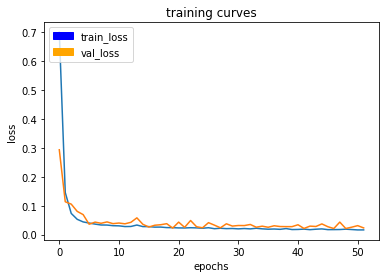

128/128 [==============================] - 54s - loss: 0.0162 - val_loss: 0.0231
Epoch 53/80
127/128 [============================>.] - ETA: 0s - loss: 0.0161

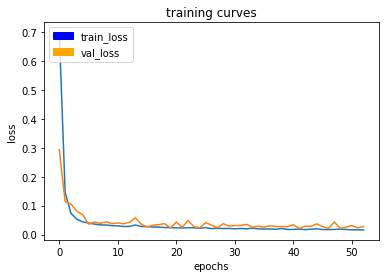

128/128 [==============================] - 54s - loss: 0.0160 - val_loss: 0.0278
Epoch 54/80
127/128 [============================>.] - ETA: 0s - loss: 0.0159

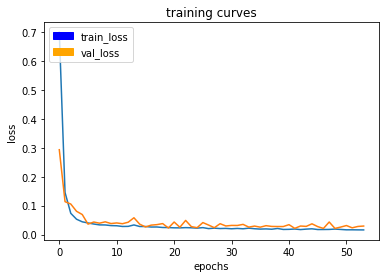

128/128 [==============================] - 54s - loss: 0.0159 - val_loss: 0.0292
Epoch 55/80
127/128 [============================>.] - ETA: 0s - loss: 0.0175

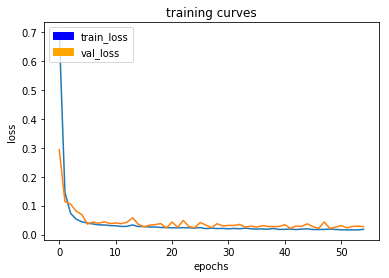

128/128 [==============================] - 54s - loss: 0.0179 - val_loss: 0.0273
Epoch 56/80
127/128 [============================>.] - ETA: 0s - loss: 0.0163

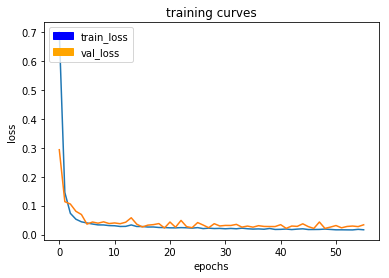

128/128 [==============================] - 54s - loss: 0.0163 - val_loss: 0.0335
Epoch 57/80
127/128 [============================>.] - ETA: 0s - loss: 0.0161

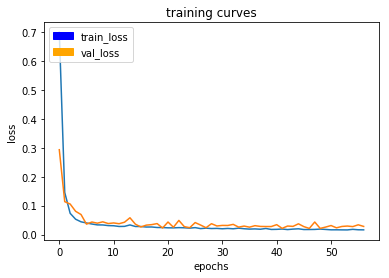

128/128 [==============================] - 54s - loss: 0.0161 - val_loss: 0.0279
Epoch 58/80
127/128 [============================>.] - ETA: 0s - loss: 0.0155

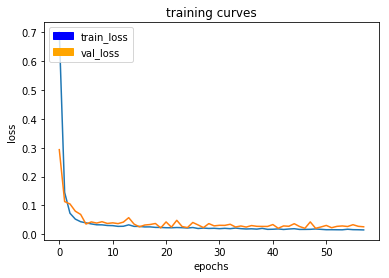

128/128 [==============================] - 54s - loss: 0.0155 - val_loss: 0.0263
Epoch 59/80
127/128 [============================>.] - ETA: 0s - loss: 0.0152

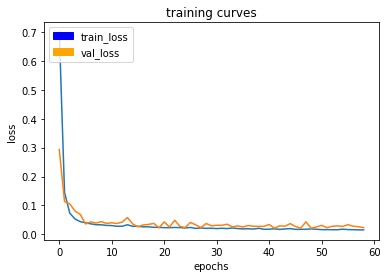

128/128 [==============================] - 54s - loss: 0.0152 - val_loss: 0.0233
Epoch 60/80
127/128 [============================>.] - ETA: 0s - loss: 0.0158

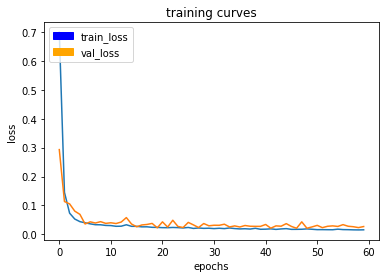

128/128 [==============================] - 54s - loss: 0.0158 - val_loss: 0.0269
Epoch 61/80
127/128 [============================>.] - ETA: 0s - loss: 0.0161

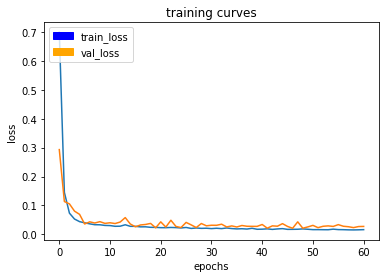

128/128 [==============================] - 54s - loss: 0.0161 - val_loss: 0.0273
Epoch 62/80
127/128 [============================>.] - ETA: 0s - loss: 0.0155

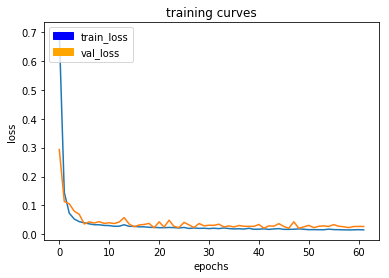

128/128 [==============================] - 54s - loss: 0.0155 - val_loss: 0.0271
Epoch 63/80
127/128 [============================>.] - ETA: 0s - loss: 0.0157

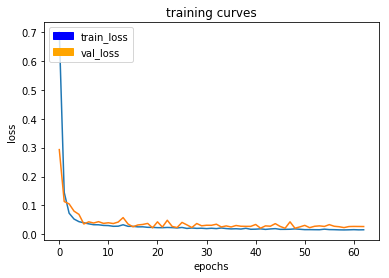

128/128 [==============================] - 54s - loss: 0.0157 - val_loss: 0.0269
Epoch 64/80
127/128 [============================>.] - ETA: 0s - loss: 0.0145

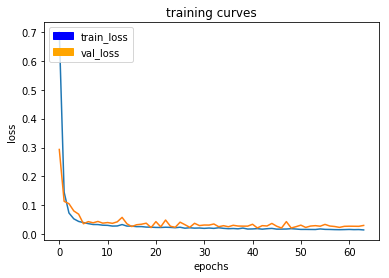

128/128 [==============================] - 54s - loss: 0.0145 - val_loss: 0.0300
Epoch 65/80
127/128 [============================>.] - ETA: 0s - loss: 0.0156

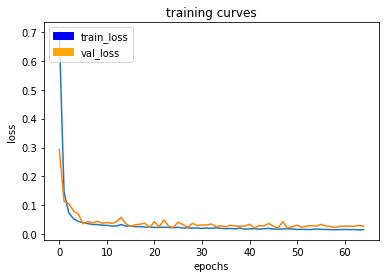

128/128 [==============================] - 54s - loss: 0.0157 - val_loss: 0.0272
Epoch 66/80
127/128 [============================>.] - ETA: 0s - loss: 0.0166

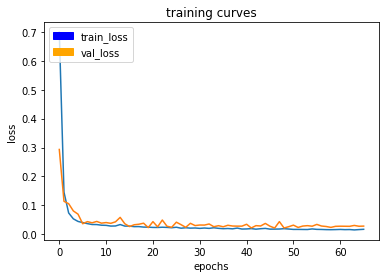

128/128 [==============================] - 55s - loss: 0.0166 - val_loss: 0.0277
Epoch 67/80
127/128 [============================>.] - ETA: 0s - loss: 0.0148

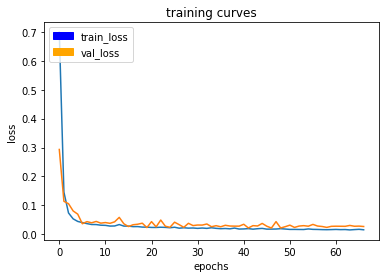

128/128 [==============================] - 54s - loss: 0.0149 - val_loss: 0.0263
Epoch 68/80
127/128 [============================>.] - ETA: 0s - loss: 0.0145

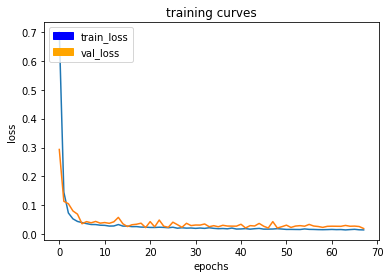

128/128 [==============================] - 54s - loss: 0.0145 - val_loss: 0.0194
Epoch 69/80
127/128 [============================>.] - ETA: 0s - loss: 0.0156

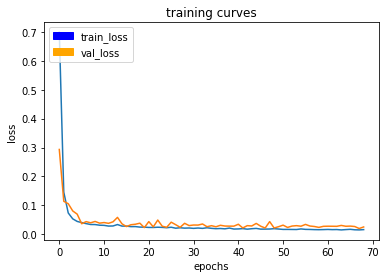

128/128 [==============================] - 54s - loss: 0.0156 - val_loss: 0.0247
Epoch 70/80
127/128 [============================>.] - ETA: 0s - loss: 0.0147

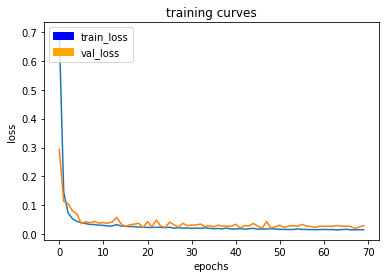

128/128 [==============================] - 54s - loss: 0.0147 - val_loss: 0.0293
Epoch 71/80
127/128 [============================>.] - ETA: 0s - loss: 0.0143

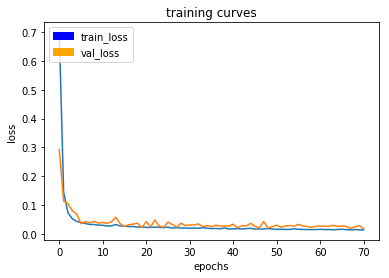

128/128 [==============================] - 54s - loss: 0.0143 - val_loss: 0.0186
Epoch 72/80
127/128 [============================>.] - ETA: 0s - loss: 0.0147

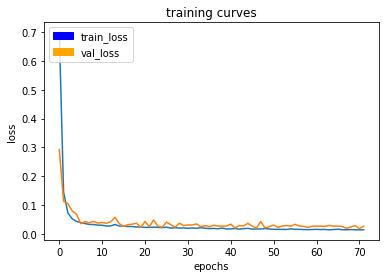

128/128 [==============================] - 54s - loss: 0.0147 - val_loss: 0.0270
Epoch 73/80
127/128 [============================>.] - ETA: 0s - loss: 0.0151

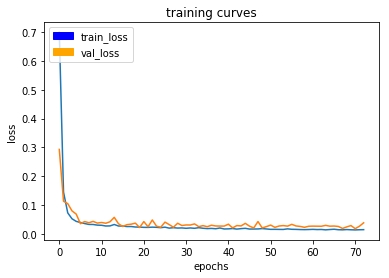

128/128 [==============================] - 54s - loss: 0.0151 - val_loss: 0.0389
Epoch 74/80
127/128 [============================>.] - ETA: 0s - loss: 0.0145

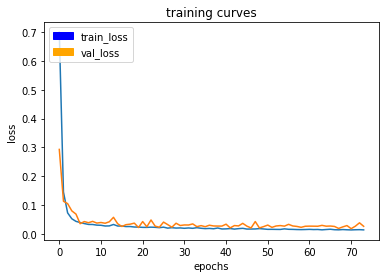

128/128 [==============================] - 54s - loss: 0.0144 - val_loss: 0.0267
Epoch 75/80
127/128 [============================>.] - ETA: 0s - loss: 0.0146

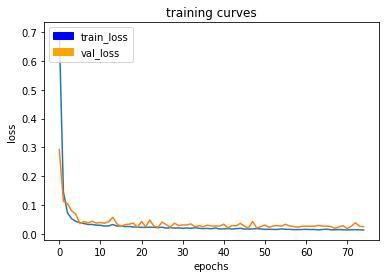

128/128 [==============================] - 54s - loss: 0.0146 - val_loss: 0.0255
Epoch 76/80
127/128 [============================>.] - ETA: 0s - loss: 0.0138

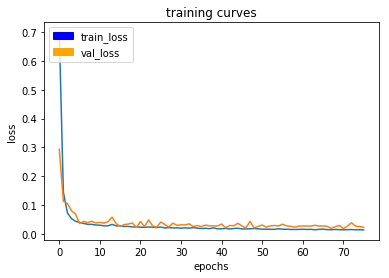

128/128 [==============================] - 54s - loss: 0.0138 - val_loss: 0.0230
Epoch 77/80
127/128 [============================>.] - ETA: 0s - loss: 0.0134

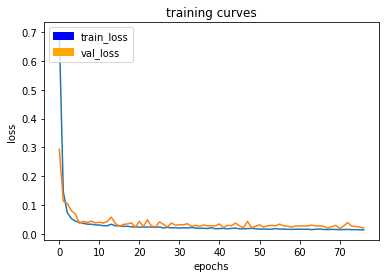

128/128 [==============================] - 54s - loss: 0.0134 - val_loss: 0.0199
Epoch 78/80
127/128 [============================>.] - ETA: 0s - loss: 0.0152

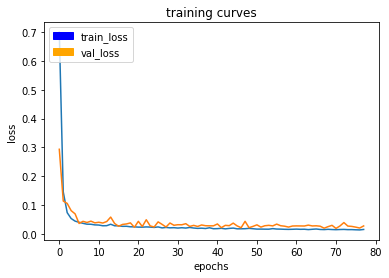

128/128 [==============================] - 54s - loss: 0.0152 - val_loss: 0.0272
Epoch 79/80
127/128 [============================>.] - ETA: 0s - loss: 0.0153

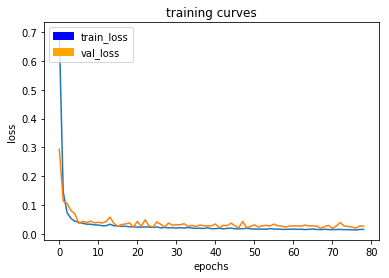

128/128 [==============================] - 54s - loss: 0.0153 - val_loss: 0.0264
Epoch 80/80
127/128 [============================>.] - ETA: 0s - loss: 0.0152

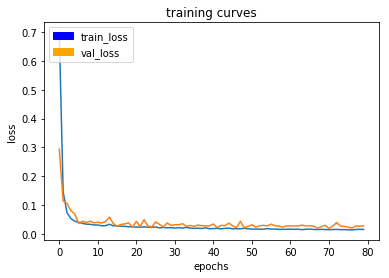

128/128 [==============================] - 54s - loss: 0.0152 - val_loss: 0.0278
number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9954890433886608
average intersection over union for other people is 0.3458723724673306
average intersection over union for the hero is 0.9058804435865931
number true positives: 539, number false positives: 1, number false negatives: 0
number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9882562295939652
average intersection over union for other people is 0.7501523127965406
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 75, number false negatives: 0
number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9965715649439747
average intersection over union for other people is 0.44256294328879

In [21]:
# Run 3
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

learning_rate = 0.001
batch_size = 32
num_epochs = 80
steps_per_epoch = int(4131/batch_size)-1#200
validation_steps = int(1000/batch_size)-1
workers = 1 # Using GPU.
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

# Save your trained model weights
weight_file_name = 'model_weights-lr001ep80_2'
model_tools.save_network(model, weight_file_name)
score_all()

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

Feature layer (?, 160, 160, 3)
Encoder 1 (?, 80, 80, 32)
Encoder 2 (?, 40, 40, 64)
Encoder 3 (?, 20, 20, 128)
1x1 Conv (?, 20, 20, 128)
Decoder 1 (?, 40, 40, 128)
Decoder 2 (?, 80, 80, 64)
Decoder 3 (?, 160, 160, 32)
Output_layer (?, 160, 160, 3)


### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [41]:
learning_rate = 0.001
batch_size = 32
num_epochs = 80
steps_per_epoch = int(4131/batch_size)-1
validation_steps = int(1000/batch_size)-1
workers = 2


Epoch 1/80
199/200 [============================>.] - ETA: 0s - loss: 0.0179

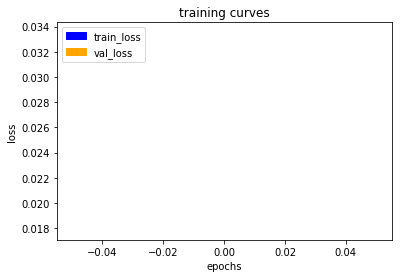

200/200 [==============================] - 82s - loss: 0.0179 - val_loss: 0.0335
Epoch 2/80
199/200 [============================>.] - ETA: 0s - loss: 0.0183

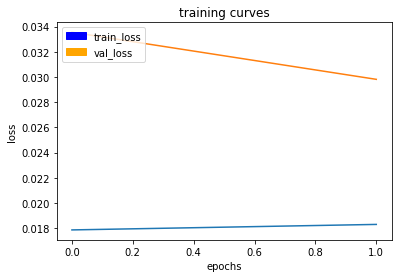

200/200 [==============================] - 81s - loss: 0.0183 - val_loss: 0.0298
Epoch 3/80
199/200 [============================>.] - ETA: 0s - loss: 0.0169

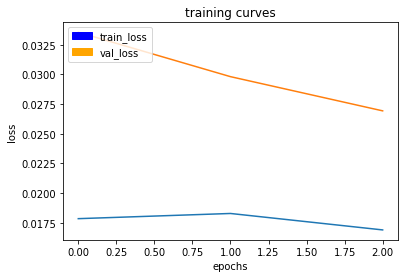

200/200 [==============================] - 81s - loss: 0.0169 - val_loss: 0.0269
Epoch 4/80
199/200 [============================>.] - ETA: 0s - loss: 0.0177

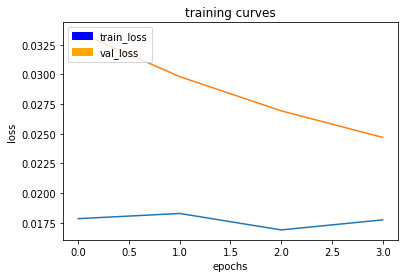

200/200 [==============================] - 81s - loss: 0.0177 - val_loss: 0.0247
Epoch 5/80
199/200 [============================>.] - ETA: 0s - loss: 0.0163

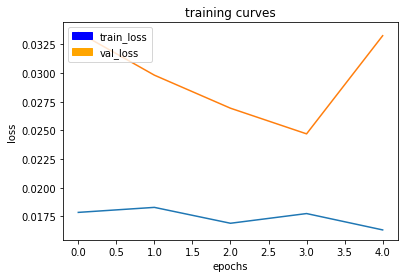

200/200 [==============================] - 81s - loss: 0.0163 - val_loss: 0.0332
Epoch 6/80
199/200 [============================>.] - ETA: 0s - loss: 0.0164

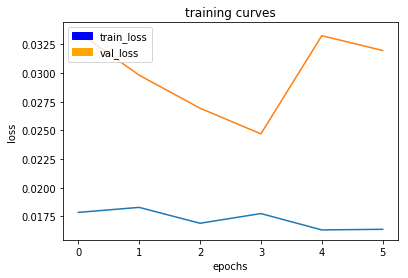

200/200 [==============================] - 81s - loss: 0.0164 - val_loss: 0.0320
Epoch 7/80
199/200 [============================>.] - ETA: 0s - loss: 0.0161

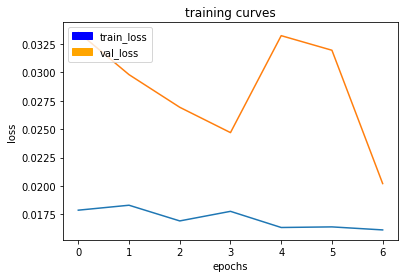

200/200 [==============================] - 81s - loss: 0.0161 - val_loss: 0.0202
Epoch 8/80
199/200 [============================>.] - ETA: 0s - loss: 0.0152

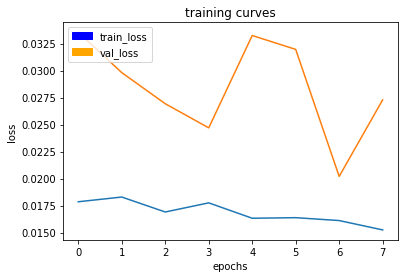

200/200 [==============================] - 81s - loss: 0.0153 - val_loss: 0.0273
Epoch 9/80
 70/200 [=========>....................] - ETA: 47s - loss: 0.0167

In [ ]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

from workspace_utils import active_session
# Keeping Your Session Active
with active_session():
    # Define the Keras model and compile it for training
    model = models.Model(inputs=inputs, outputs=output_layer)

    model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

    # Data iterators for loading the training and validation data
    train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                                   data_folder=os.path.join('..', 'data', 'train'),
                                                   image_shape=image_shape,
                                                   shift_aug=True)

    val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                                 data_folder=os.path.join('..', 'data', 'validation'),
                                                 image_shape=image_shape)

    logger_cb = plotting_tools.LoggerPlotter()
    callbacks = [logger_cb]

    model.fit_generator(train_iter,
                        steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                        epochs = num_epochs, # the number of epochs to train for,
                        validation_data = val_iter, # validation iterator
                        validation_steps = validation_steps, # the number of batches to validate on
                        callbacks=callbacks,
                        workers = workers)

In [10]:
# Save your trained model weights
weight_file_name = 'model_weights_1_29_1_49t_lr01_batch_size_100_epochs_40_1sep_in_dec'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [11]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [22]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

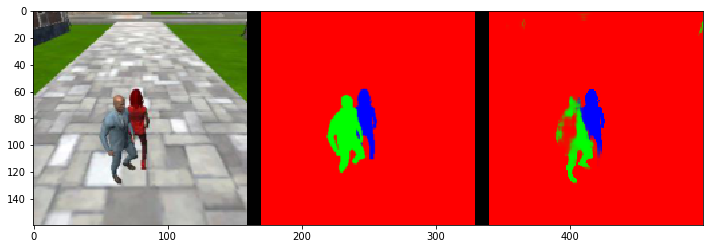

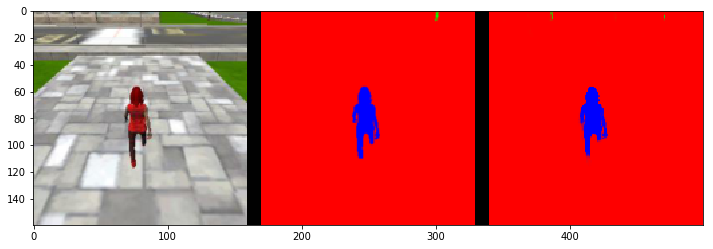

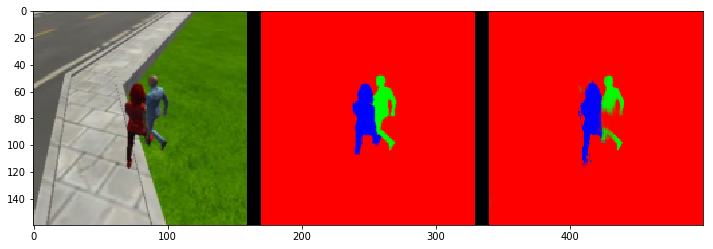

In [23]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

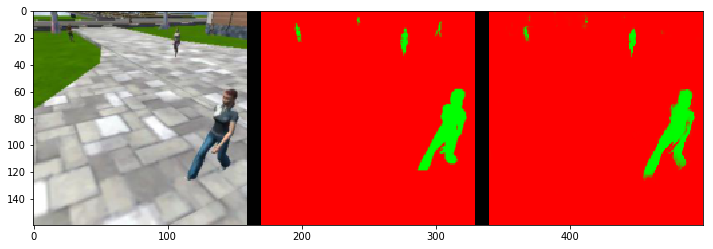

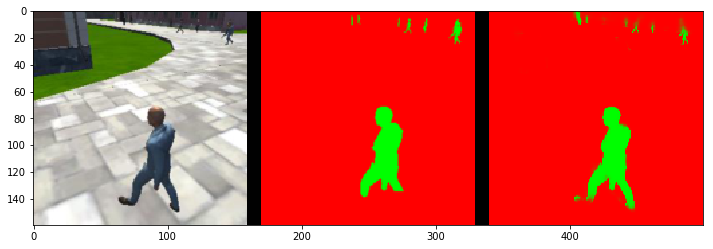

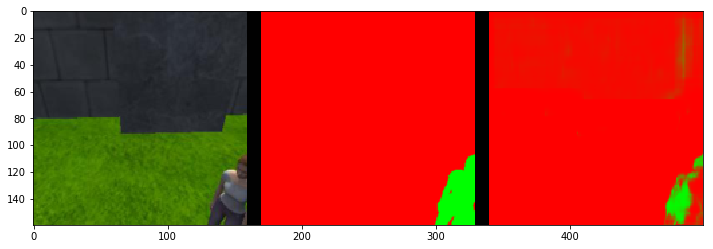

In [12]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

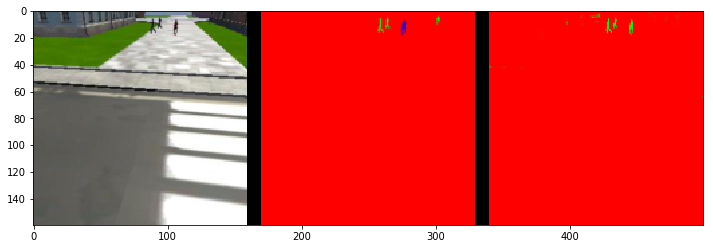

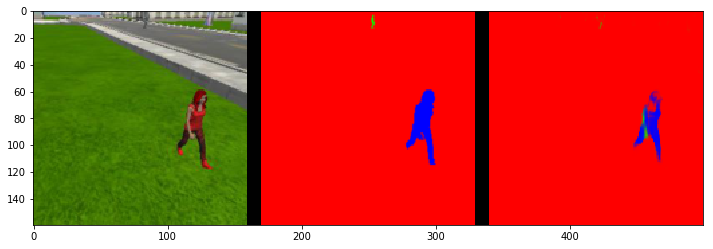

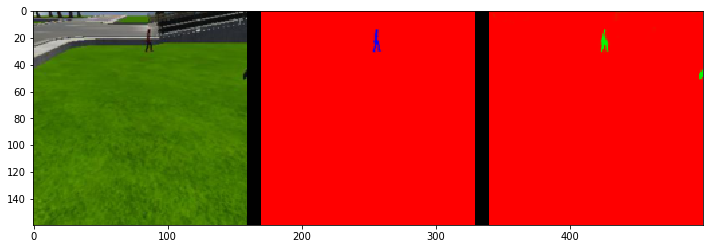

In [14]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [24]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9954890433886608
average intersection over union for other people is 0.3458723724673306
average intersection over union for the hero is 0.9058804435865931
number true positives: 539, number false positives: 1, number false negatives: 0


In [25]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9882562295939652
average intersection over union for other people is 0.7501523127965406
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 75, number false negatives: 0


In [26]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9965715649439747
average intersection over union for other people is 0.4425629432887988
average intersection over union for the hero is 0.23930189225590606
number true positives: 154, number false positives: 4, number false negatives: 147


In [27]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7532608695652174


In [28]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.572591167921


In [29]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.431310521054
